In [1]:
# ======================================================
# 1. SETUP & REPRODUCIBILITY
# ======================================================
import os
import random
import numpy as np
import tensorflow as tf

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ======================================================
# 2. MOUNT DRIVE & IMPORTS
# ======================================================
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install numpy tensorflow scikit-learn keras pandas seaborn matplotlib

Loading UC Merced Land Use dataset...
Loaded 2100 images from 21 classes

🔹 Class distribution (UC Merced Dataset):
            Class  Samples
     agricultural      100
         airplane      100
  baseballdiamond      100
            beach      100
        buildings      100
        chaparral      100
 denseresidential      100
           forest      100
          freeway      100
       golfcourse      100
           harbor      100
     intersection      100
mediumresidential      100
   mobilehomepark      100
         overpass      100
       parkinglot      100
            river      100
           runway      100
sparseresidential      100
     storagetanks      100
      tenniscourt      100


/tmp/ipython-input-4157759820.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Class', x='Samples', data=dist_df, palette='viridis')


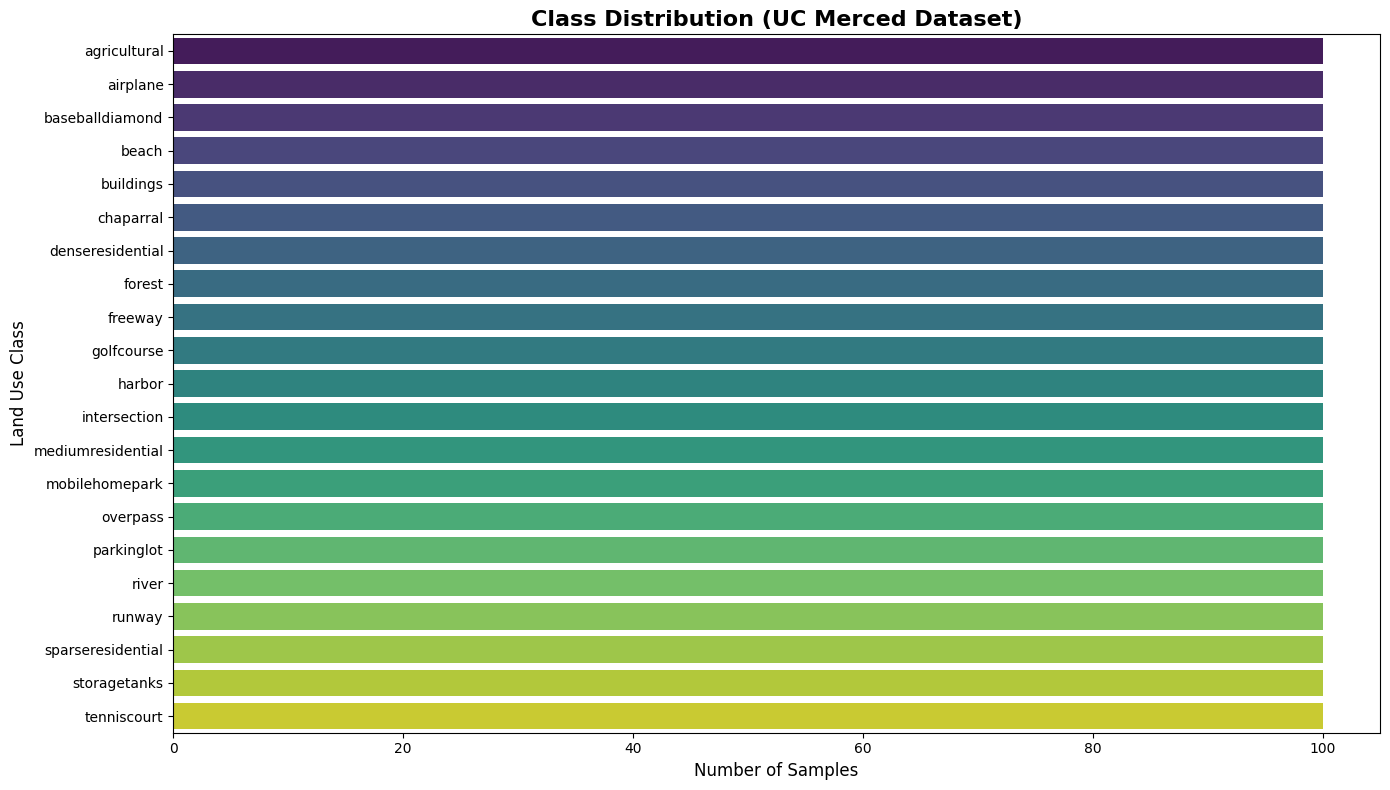

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tensorflow.keras.models import Model

# ===============================
# Dataset variables
# ===============================
image_dir = '/content/drive/MyDrive/UCMerced_LandUse/Images'
image_shape = (128, 128)
num_classes = 21  # 21 land use classes
batch_size = 32

# ===============================
# Data loading
# ===============================
def load_data(image_dir, image_shape):
    images = []
    labels = []
    file_paths = []

    for class_name in sorted(os.listdir(image_dir)):
        class_dir = os.path.join(image_dir, class_name)
        if os.path.isdir(class_dir):
            for file_name in os.listdir(class_dir):
                file_path = os.path.join(class_dir, file_name)
                try:
                    image = tf.keras.preprocessing.image.load_img(file_path, target_size=image_shape)
                    image = tf.keras.preprocessing.image.img_to_array(image)
                    images.append(image)
                    labels.append(class_name)
                    file_paths.append(file_path)
                except Exception:
                    continue

    images = np.array(images)
    labels = np.array(labels)
    file_paths = np.array(file_paths)
    return images, labels, file_paths

def preprocess_data(images, labels, num_classes):
    images = images / 255.0  # normalize
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    labels_categorical = tf.keras.utils.to_categorical(labels_encoded, num_classes)
    return images, labels_categorical, label_encoder

# Load UC Merced dataset
print("Loading UC Merced Land Use dataset...")
images, labels, file_paths = load_data(image_dir, image_shape)
images, labels_categorical, label_encoder = preprocess_data(images, labels, num_classes)
print(f"Loaded {len(images)} images from {num_classes} classes")

# ===============================
# Class distribution visualization
# ===============================
def display_class_distribution(labels, label_encoder, title=""):
    classes = np.argmax(labels, axis=1)
    unique, counts = np.unique(classes, return_counts=True)
    class_names = label_encoder.inverse_transform(unique)
    dist_df = pd.DataFrame({'Class': class_names, 'Samples': counts})
    print(f"\n🔹 Class distribution {title}:")
    print(dist_df.to_string(index=False))

    plt.figure(figsize=(14, 8))
    sns.barplot(y='Class', x='Samples', data=dist_df, palette='viridis')
    plt.title(f"Class Distribution {title}", fontsize=16, fontweight='bold')
    plt.xlabel("Number of Samples", fontsize=12)
    plt.ylabel("Land Use Class", fontsize=12)
    plt.tight_layout()
    plt.show()

display_class_distribution(labels_categorical, label_encoder, title="(UC Merced Dataset)")


In [4]:
# ===============================
# Train-test split (with file paths tracking)
# ===============================
X_train, X_test, y_train, y_test, paths_train, paths_test = train_test_split(
    images, labels_categorical, file_paths, test_size=0.2, random_state=42, stratify=labels_categorical
)

print(f"\nTrain set: {len(X_train)} images")
print(f"Test set: {len(X_test)} images")



Train set: 1680 images
Test set: 420 images


In [5]:

# ===============================
# Data augmentation
# ===============================
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)


In [6]:

# ===============================
# FuzzyMembershipLayer definition
# ===============================
class FuzzyMembershipLayer(Layer):
    def __init__(self, num_classes, **kwargs):
        super(FuzzyMembershipLayer, self).__init__(**kwargs)
        self.num_classes = num_classes

    def build(self, input_shape):
        self.centers = self.add_weight(
            name='centers',
            shape=(input_shape[-1], self.num_classes),
            initializer='glorot_uniform',
            trainable=True)
        super(FuzzyMembershipLayer, self).build(input_shape)

    def call(self, inputs):
        inputs_norm = tf.nn.l2_normalize(inputs, axis=1)
        centers_norm = tf.nn.l2_normalize(self.centers, axis=0)
        membership = tf.matmul(inputs_norm, centers_norm)
        temperature = 10.0
        return tf.nn.softmax(membership * temperature)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.num_classes)

    def get_config(self):
        config = super().get_config()
        config.update({"num_classes": self.num_classes})
        return config

# ===============================
# Final fuzzy model builder
# ===============================
def build_final_fuzzy_model(input_shape=(128,128,3), num_classes=21):
    base_model = tf.keras.applications.VGG19(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape)

    # Freeze first layers, fine-tune deeper ones
    for layer in base_model.layers[:15]:
        layer.trainable = False
    for layer in base_model.layers[15:]:
        layer.trainable = True

    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    fuzzy_output = FuzzyMembershipLayer(num_classes=num_classes, name='fuzzy_membership')(x)

    # Focal loss for multi-class
    def focal_loss(y_true, y_pred):
        gamma = 2.0
        alpha = 0.25
        epsilon = 1e-8
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * y_true * tf.pow(1.0 - y_pred, gamma)
        loss = weight * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))

    model = tf.keras.Model(inputs=base_model.input, outputs=fuzzy_output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=focal_loss,
        metrics=['accuracy',
                 tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy'),
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall')]
    )
    return model

final_fuzzy_model = build_final_fuzzy_model(input_shape=(128,128,3), num_classes=num_classes)
final_fuzzy_model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,299,840 (77.44 MB)

 Trainable params: 12,073,472 (46.06 MB)

 Non-trainable params: 8,226,368 (31.38 MB)

In [7]:
# ===============================
# K-FOLD CROSS VALIDATION
# ===============================
from sklearn.model_selection import StratifiedKFold

k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Convert one-hot labels to class indices for stratification
labels_indices = np.argmax(labels_categorical, axis=1)

fold_histories = []
fold_accuracies = []

print(f"\n🔁 Starting {k_folds}-Fold Cross-Validation...\n")

for fold, (train_idx, val_idx) in enumerate(skf.split(images, labels_indices), 1):
    print("="*60)
    print(f"🚀 Fold {fold}/{k_folds}")
    print("="*60)

    # Split data
    X_train_fold, X_val_fold = images[train_idx], images[val_idx]
    y_train_fold, y_val_fold = labels_categorical[train_idx], labels_categorical[val_idx]

    print(f"Train samples: {len(X_train_fold)} | Validation samples: {len(X_val_fold)}")

    # Data augmentation
    train_generator = train_datagen.flow(
        X_train_fold, y_train_fold, batch_size=batch_size, shuffle=True
    )

    # Build a NEW model for each fold
    model = build_final_fuzzy_model(
        input_shape=(128, 128, 3),
        num_classes=num_classes
    )

    # Callbacks (optional: fold-specific checkpoint)
    callbacks = [
        EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)
    ]

    # Train
    history = model.fit(
        train_generator,
        validation_data=(X_val_fold, y_val_fold),
        epochs=40,
        steps_per_epoch=len(X_train_fold) // batch_size,
        callbacks=callbacks,
        verbose=1
    )

    # Evaluate fold
    scores = model.evaluate(X_val_fold, y_val_fold, verbose=0, return_dict=True)
    fold_accuracy = scores['accuracy']

    print(f"✅ Fold {fold} Accuracy: {fold_accuracy*100:.2f}%")

    fold_histories.append(history)
    fold_accuracies.append(fold_accuracy)

# ===============================
# K-FOLD SUMMARY
# ===============================
print("\n" + "="*60)
print("📊 K-FOLD CROSS-VALIDATION RESULTS")
print("="*60)
print(f"Accuracies per fold: {[f'{acc*100:.2f}%' for acc in fold_accuracies]}")
print(f"Mean Accuracy: {np.mean(fold_accuracies)*100:.2f}%")
print(f"Std Deviation: {np.std(fold_accuracies)*100:.2f}%")
print("="*60)
print(f"Loaded {len(images)} images from {num_classes} classes")



🔁 Starting 5-Fold Cross-Validation...

🚀 Fold 1/5
Train samples: 1680 | Validation samples: 420


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 42s 412ms/step - accuracy: 0.2724 - loss: 0.5537 - precision: 0.3396 - recall: 0.0021 - top_3_accuracy: 0.4858 - val_accuracy: 0.5786 - val_loss: 0.3385 - val_precision: 1.0000 - val_recall: 0.0405 - val_top_3_accuracy: 0.8048 - learning_rate: 1.0000e-04
Epoch 2/40
 1/52 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.7500 - loss: 0.2447 - precision: 1.0000 - recall: 0.0625 - top_3_accuracy: 0.8750

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7500 - loss: 0.2447 - precision: 1.0000 - recall: 0.0625 - top_3_accuracy: 0.8750 - val_accuracy: 0.5929 - val_loss: 0.3315 - val_precision: 1.0000 - val_recall: 0.0500 - val_top_3_accuracy: 0.8095 - learning_rate: 1.0000e-04
Epoch 3/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 177ms/step - accuracy: 0.7097 - loss: 0.2256 - precision: 0.9974 - recall: 0.1186 - top_3_accuracy: 0.9319 - val_accuracy: 0.8048 - val_loss: 0.1315 - val_precision: 0.9812 - val_recall: 0.3738 - val_top_3_accuracy: 0.9786 - learning_rate: 1.0000e-04
Epoch 4/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8125 - loss: 0.1486 - precision: 1.0000 - recall: 0.2812 - top_3_accuracy: 0.9688 - val_accuracy: 0.8262 - val_loss: 0.1255 - val_precision: 0.9661 - val_recall: 0.4071 - val_top_3_accuracy: 0.9786 - learning_rate: 1.0000e-04
Epoch 5/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 182ms/step - accuracy: 0.8377 - loss: 0.1171 - precision: 0.9780 - recall: 0.3955 - top_3_accur

In [8]:

# ===============================
# Training
# ===============================
callbacks = [
    ModelCheckpoint('best_ucmerced_fuzzy_model.h5', monitor='val_accuracy', save_best_only=True, mode='max'),
    EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-7, verbose=1)
]

print("\nStarting training...")
history = final_fuzzy_model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)


Starting training...
Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.3187 - loss: 0.5318 - precision: 0.4423 - recall: 0.0026 - top_3_accuracy: 0.5369

52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 307ms/step - accuracy: 0.3214 - loss: 0.5298 - precision: 0.4528 - recall: 0.0027 - top_3_accuracy: 0.5399 - val_accuracy: 0.6857 - val_loss: 0.3247 - val_precision: 1.0000 - val_recall: 0.0738 - val_top_3_accuracy: 0.8619 - learning_rate: 1.0000e-04
Epoch 2/50
 1/52 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.6250 - loss: 0.2278 - precision: 1.0000 - recall: 0.0625 - top_3_accuracy: 1.0000

52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - accuracy: 0.6250 - loss: 0.2278 - precision: 1.0000 - recall: 0.0625 - top_3_accuracy: 1.0000 - val_accuracy: 0.6905 - val_loss: 0.3172 - val_precision: 1.0000 - val_recall: 0.0738 - val_top_3_accuracy: 0.8571 - learning_rate: 1.0000e-04
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.7550 - loss: 0.1967 - precision: 0.9972 - recall: 0.1774 - top_3_accuracy: 0.9476

52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 197ms/step - accuracy: 0.7552 - loss: 0.1964 - precision: 0.9971 - recall: 0.1784 - top_3_accuracy: 0.9476 - val_accuracy: 0.8262 - val_loss: 0.1462 - val_precision: 0.9934 - val_recall: 0.3595 - val_top_3_accuracy: 0.9452 - learning_rate: 1.0000e-04
Epoch 4/50
 1/52 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.7812 - loss: 0.1201 - precision: 1.0000 - recall: 0.3125 - top_3_accuracy: 1.0000

52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7812 - loss: 0.1201 - precision: 1.0000 - recall: 0.3125 - top_3_accuracy: 1.0000 - val_accuracy: 0.8357 - val_loss: 0.1426 - val_precision: 0.9871 - val_recall: 0.3643 - val_top_3_accuracy: 0.9500 - learning_rate: 1.0000e-04
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 188ms/step - accuracy: 0.8754 - loss: 0.1029 - precision: 0.9875 - recall: 0.4551 - top_3_accuracy: 0.9752 - val_accuracy: 0.8190 - val_loss: 0.0851 - val_precision: 0.9401 - val_recall: 0.7095 - val_top_3_accuracy: 0.9571 - learning_rate: 1.0000e-04
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9375 - loss: 0.0705 - precision: 1.0000 - recall: 0.6875 - top_3_accuracy: 1.0000 - val_accuracy: 0.7976 - val_loss: 0.0953 - val_precision: 0.9123 - val_recall: 0.6690 - val_top_3_accuracy: 0.9619 - learning_rate: 1.0000e-04
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.8714 - loss: 0.0808 - precision: 0.9677 - recall: 0.6160 - top_3_accur

52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 195ms/step - accuracy: 0.8715 - loss: 0.0807 - precision: 0.9678 - recall: 0.6165 - top_3_accuracy: 0.9825 - val_accuracy: 0.8643 - val_loss: 0.0740 - val_precision: 0.9176 - val_recall: 0.7952 - val_top_3_accuracy: 0.9667 - learning_rate: 1.0000e-04
Epoch 8/50
 1/52 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 0.9375 - loss: 0.0506 - precision: 1.0000 - recall: 0.7188 - top_3_accuracy: 1.0000

52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9375 - loss: 0.0506 - precision: 1.0000 - recall: 0.7188 - top_3_accuracy: 1.0000 - val_accuracy: 0.8714 - val_loss: 0.0687 - val_precision: 0.9307 - val_recall: 0.8000 - val_top_3_accuracy: 0.9714 - learning_rate: 1.0000e-04
Epoch 9/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.8998 - loss: 0.0597 - precision: 0.9793 - recall: 0.7120 - top_3_accuracy: 0.9890

52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 193ms/step - accuracy: 0.9001 - loss: 0.0596 - precision: 0.9794 - recall: 0.7127 - top_3_accuracy: 0.9890 - val_accuracy: 0.8810 - val_loss: 0.0523 - val_precision: 0.9211 - val_recall: 0.8333 - val_top_3_accuracy: 0.9786 - learning_rate: 1.0000e-04
Epoch 10/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8438 - loss: 0.0593 - precision: 1.0000 - recall: 0.6250 - top_3_accuracy: 1.0000 - val_accuracy: 0.8714 - val_loss: 0.0553 - val_precision: 0.9229 - val_recall: 0.8262 - val_top_3_accuracy: 0.9738 - learning_rate: 1.0000e-04
Epoch 11/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9232 - loss: 0.0441 - precision: 0.9776 - recall: 0.7989 - top_3_accuracy: 0.9952

52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 202ms/step - accuracy: 0.9230 - loss: 0.0441 - precision: 0.9775 - recall: 0.7990 - top_3_accuracy: 0.9952 - val_accuracy: 0.9048 - val_loss: 0.0336 - val_precision: 0.9229 - val_recall: 0.8833 - val_top_3_accuracy: 0.9929 - learning_rate: 1.0000e-04
Epoch 12/50
 1/52 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.9062 - loss: 0.0342 - precision: 0.9615 - recall: 0.7812 - top_3_accuracy: 1.0000

52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9062 - loss: 0.0342 - precision: 0.9615 - recall: 0.7812 - top_3_accuracy: 1.0000 - val_accuracy: 0.9214 - val_loss: 0.0310 - val_precision: 0.9421 - val_recall: 0.8905 - val_top_3_accuracy: 0.9952 - learning_rate: 1.0000e-04
Epoch 13/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 198ms/step - accuracy: 0.9345 - loss: 0.0362 - precision: 0.9724 - recall: 0.8322 - top_3_accuracy: 0.9944 - val_accuracy: 0.8786 - val_loss: 0.0560 - val_precision: 0.9207 - val_recall: 0.8571 - val_top_3_accuracy: 0.9833 - learning_rate: 1.0000e-04
Epoch 14/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8750 - loss: 0.0631 - precision: 1.0000 - recall: 0.7812 - top_3_accuracy: 0.9688 - val_accuracy: 0.8690 - val_loss: 0.0660 - val_precision: 0.8939 - val_recall: 0.8429 - val_top_3_accuracy: 0.9833 - learning_rate: 1.0000e-04
Epoch 15/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 201ms/step - accuracy: 0.9305 - loss: 0.0364 - precision: 0.9744 - recall: 0.8367 - top_3_a

52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 240ms/step - accuracy: 0.9584 - loss: 0.0190 - precision: 0.9818 - recall: 0.9038 - top_3_accuracy: 0.9963 - val_accuracy: 0.9286 - val_loss: 0.0248 - val_precision: 0.9484 - val_recall: 0.9190 - val_top_3_accuracy: 0.9952 - learning_rate: 5.0000e-05
Epoch 22/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 1.0000 - loss: 0.0069 - precision: 1.0000 - recall: 0.9688 - top_3_accuracy: 1.0000 - val_accuracy: 0.9286 - val_loss: 0.0260 - val_precision: 0.9484 - val_recall: 0.9190 - val_top_3_accuracy: 0.9929 - learning_rate: 5.0000e-05
Epoch 23/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9702 - loss: 0.0138 - precision: 0.9862 - recall: 0.9266 - top_3_accuracy: 0.9991

52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 198ms/step - accuracy: 0.9703 - loss: 0.0138 - precision: 0.9862 - recall: 0.9268 - top_3_accuracy: 0.9991 - val_accuracy: 0.9405 - val_loss: 0.0213 - val_precision: 0.9534 - val_recall: 0.9262 - val_top_3_accuracy: 0.9905 - learning_rate: 5.0000e-05
Epoch 24/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9688 - loss: 0.0122 - precision: 1.0000 - recall: 0.9375 - top_3_accuracy: 1.0000 - val_accuracy: 0.9405 - val_loss: 0.0203 - val_precision: 0.9513 - val_recall: 0.9310 - val_top_3_accuracy: 0.9905 - learning_rate: 5.0000e-05
Epoch 25/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9775 - loss: 0.0107 - precision: 0.9904 - recall: 0.9503 - top_3_accuracy: 1.0000

52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 193ms/step - accuracy: 0.9775 - loss: 0.0107 - precision: 0.9904 - recall: 0.9502 - top_3_accuracy: 1.0000 - val_accuracy: 0.9571 - val_loss: 0.0134 - val_precision: 0.9660 - val_recall: 0.9476 - val_top_3_accuracy: 0.9976 - learning_rate: 5.0000e-05
Epoch 26/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9688 - loss: 0.0147 - precision: 0.9688 - recall: 0.9688 - top_3_accuracy: 1.0000 - val_accuracy: 0.9571 - val_loss: 0.0140 - val_precision: 0.9636 - val_recall: 0.9452 - val_top_3_accuracy: 1.0000 - learning_rate: 5.0000e-05
Epoch 27/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9777 - loss: 0.0121 - precision: 0.9884 - recall: 0.9447 - top_3_accuracy: 1.0000

52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 194ms/step - accuracy: 0.9778 - loss: 0.0121 - precision: 0.9884 - recall: 0.9449 - top_3_accuracy: 1.0000 - val_accuracy: 0.9595 - val_loss: 0.0191 - val_precision: 0.9663 - val_recall: 0.9548 - val_top_3_accuracy: 0.9881 - learning_rate: 5.0000e-05
Epoch 28/50
 1/52 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 1.0000 - loss: 0.0037 - precision: 1.0000 - recall: 1.0000 - top_3_accuracy: 1.0000

52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 1.0000 - loss: 0.0037 - precision: 1.0000 - recall: 1.0000 - top_3_accuracy: 1.0000 - val_accuracy: 0.9619 - val_loss: 0.0185 - val_precision: 0.9662 - val_recall: 0.9524 - val_top_3_accuracy: 0.9881 - learning_rate: 5.0000e-05
Epoch 29/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 196ms/step - accuracy: 0.9853 - loss: 0.0076 - precision: 0.9946 - recall: 0.9566 - top_3_accuracy: 0.9996 - val_accuracy: 0.9595 - val_loss: 0.0193 - val_precision: 0.9680 - val_recall: 0.9357 - val_top_3_accuracy: 0.9929 - learning_rate: 5.0000e-05
Epoch 30/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9688 - loss: 0.0193 - precision: 0.9667 - recall: 0.9062 - top_3_accuracy: 1.0000 - val_accuracy: 0.9524 - val_loss: 0.0198 - val_precision: 0.9656 - val_recall: 0.9357 - val_top_3_accuracy: 0.9929 - learning_rate: 5.0000e-05
Epoch 31/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 200ms/step - accuracy: 0.9843 - loss: 0.0084 - precision: 0.9958 - recall: 0.9585 - top_3_a

52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 198ms/step - accuracy: 0.9916 - loss: 0.0043 - precision: 0.9969 - recall: 0.9826 - top_3_accuracy: 1.0000 - val_accuracy: 0.9643 - val_loss: 0.0172 - val_precision: 0.9758 - val_recall: 0.9619 - val_top_3_accuracy: 0.9952 - learning_rate: 2.5000e-05
Epoch 42/50
 1/52 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 0.0023 - precision: 1.0000 - recall: 1.0000 - top_3_accuracy: 1.0000
Epoch 42: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 1.0000 - loss: 0.0023 - precision: 1.0000 - recall: 1.0000 - top_3_accuracy: 1.0000 - val_accuracy: 0.9643 - val_loss: 0.0173 - val_precision: 0.9782 - val_recall: 0.9595 - val_top_3_accuracy: 0.9929 - learning_rate: 2.5000e-05
Epoch 43/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 197ms/step - accuracy: 0.9959 - loss: 0.0042 - precision: 0.9997 - recall: 0.9869 - top_3_accuracy: 1.0000 - val_accuracy: 0.9571 - val_loss: 0.0176 - val_precision: 0.9


Evaluating model...
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step

🔹 Classification Report (UC Merced Land Use):
                   precision    recall  f1-score   support

     agricultural       1.00      0.95      0.97        20
         airplane       0.95      1.00      0.98        20
  baseballdiamond       1.00      1.00      1.00        20
            beach       0.95      1.00      0.98        20
        buildings       1.00      0.90      0.95        20
        chaparral       1.00      1.00      1.00        20
 denseresidential       0.83      0.95      0.88        20
           forest       0.95      1.00      0.98        20
          freeway       1.00      0.95      0.97        20
       golfcourse       1.00      0.95      0.97        20
           harbor       1.00      1.00      1.00        20
     intersection       1.00      0.95      0.97        20
mediumresidential       0.85      0.85      0.85        20
   mobilehomepark       1.00      1.00      1.00        20
     

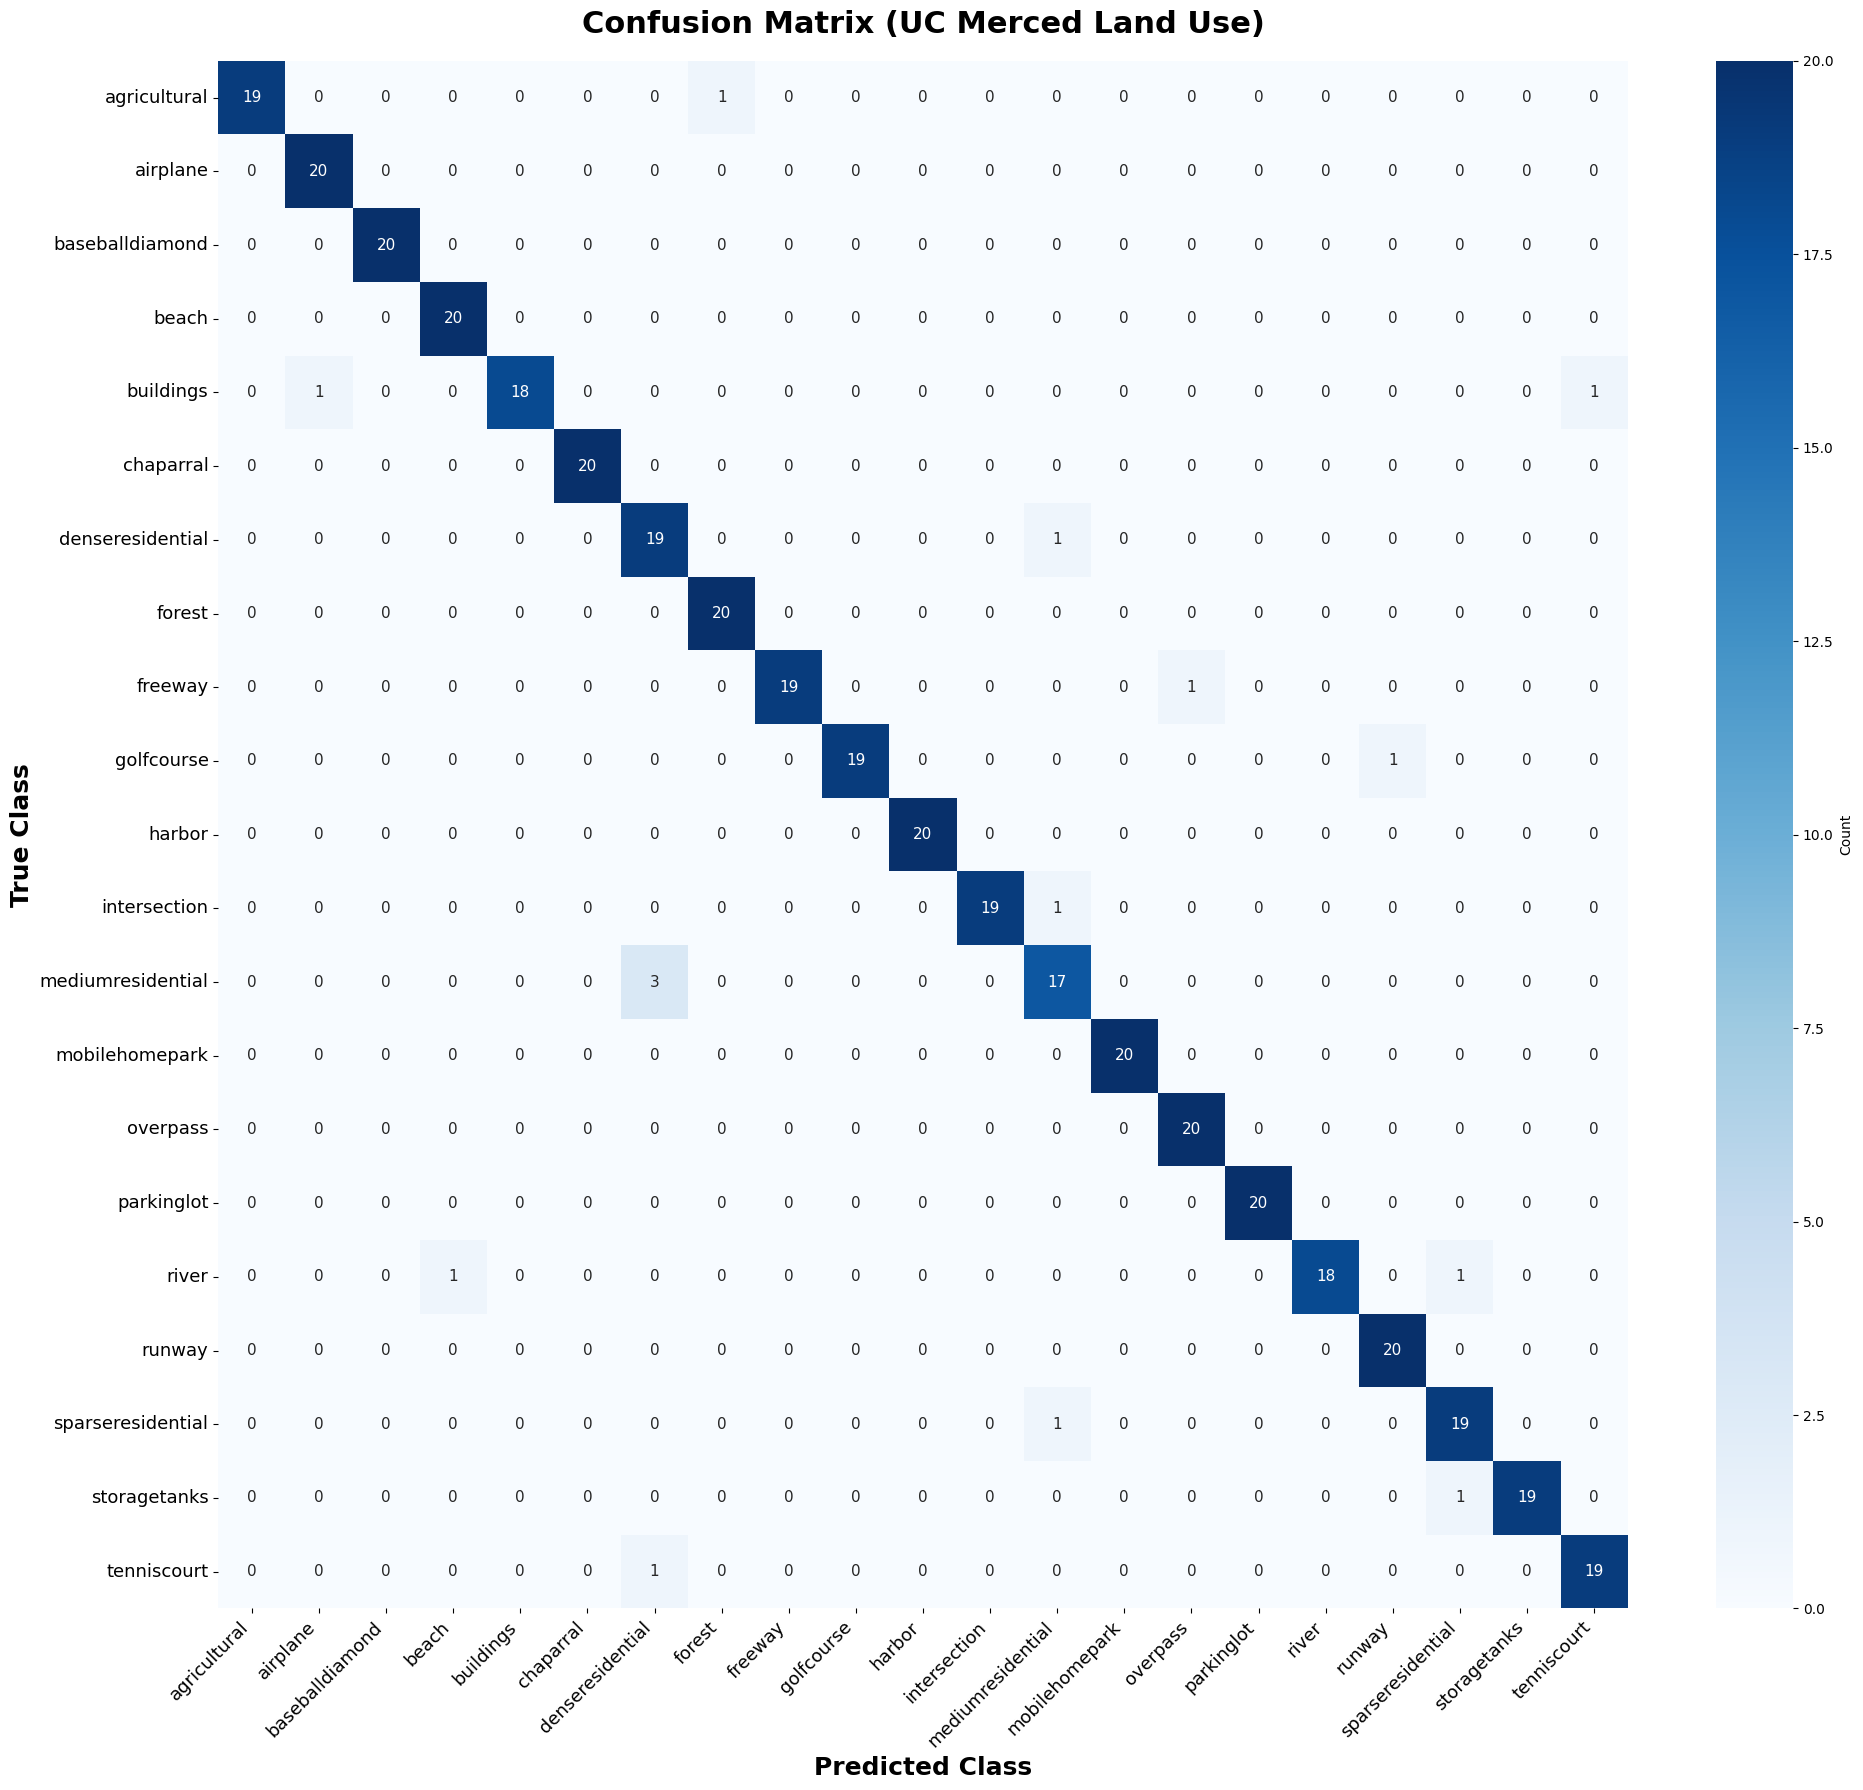

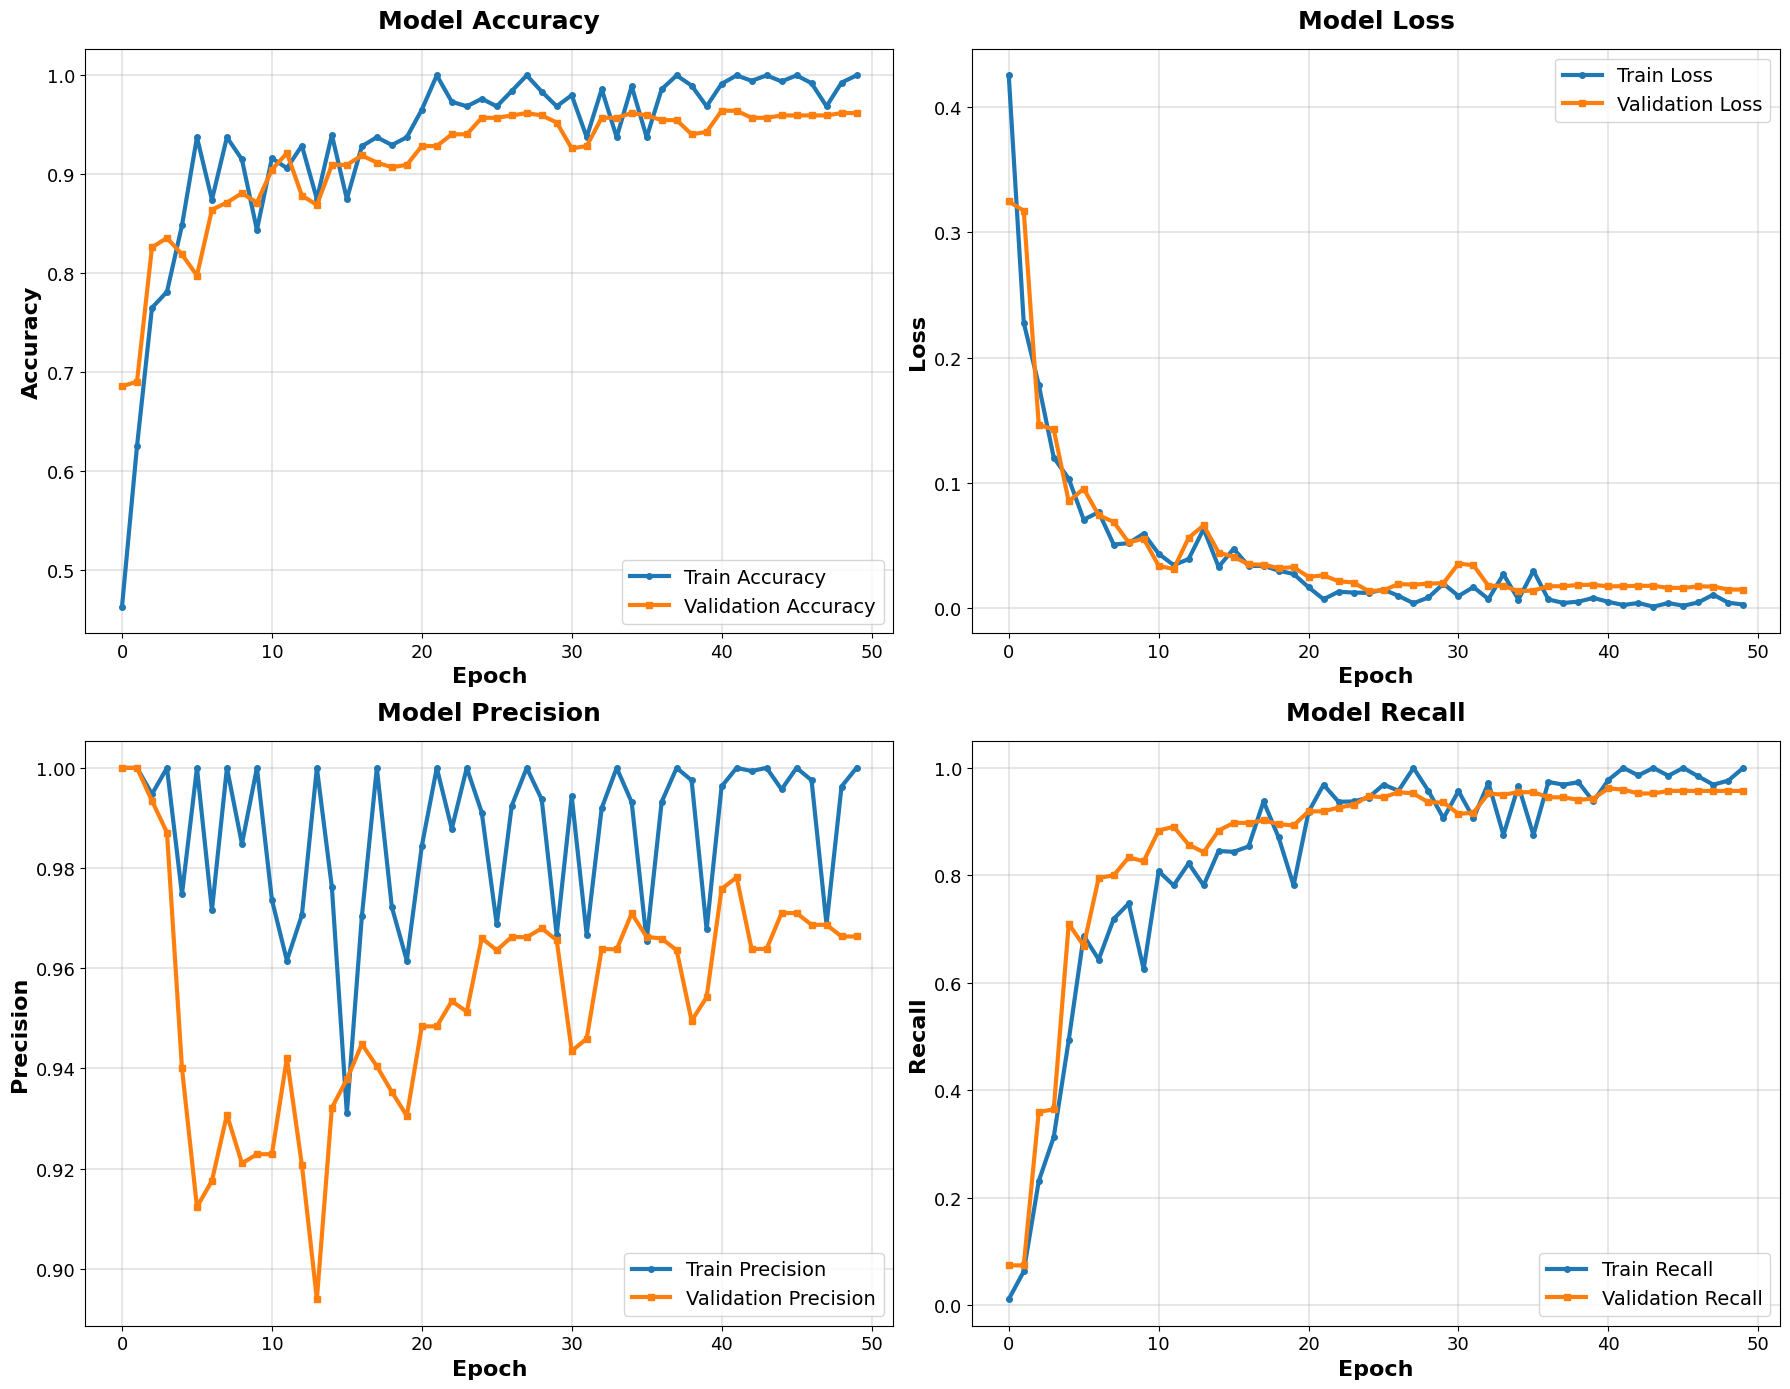

In [9]:
# ===============================
# Evaluation
# ===============================
print("\nEvaluating model...")
y_pred = final_fuzzy_model.predict(X_test, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Get prediction confidence (max probability)
prediction_confidence = np.max(y_pred, axis=1)

print("\n🔹 Classification Report (UC Merced Land Use):")
print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))

# ===============================
# Confusion Matrix - HIGH QUALITY
# ===============================
plt.figure(figsize=(20, 18))
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'},
            annot_kws={'size': 11})
plt.title('Confusion Matrix (UC Merced Land Use)', fontsize=22, fontweight='bold', pad=20)
plt.xlabel('Predicted Class', fontsize=18, fontweight='bold')
plt.ylabel('True Class', fontsize=18, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=13)
plt.yticks(rotation=0, fontsize=13)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# ===============================
# Training curves - HIGH QUALITY
# ===============================
def plot_metrics(history):
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))

    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=3, marker='o', markersize=4)
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=3, marker='s', markersize=4)
    axes[0, 0].set_title('Model Accuracy', fontsize=18, fontweight='bold', pad=15)
    axes[0, 0].set_xlabel('Epoch', fontsize=16, fontweight='bold')
    axes[0, 0].set_ylabel('Accuracy', fontsize=16, fontweight='bold')
    axes[0, 0].legend(loc='lower right', fontsize=14)
    axes[0, 0].grid(True, alpha=0.3, linewidth=1.5)
    axes[0, 0].tick_params(labelsize=13)

    # Loss
    axes[0, 1].plot(history.history['loss'], label='Train Loss', linewidth=3, marker='o', markersize=4)
    axes[0, 1].plot(history.history['val_loss'], label='Validation Loss', linewidth=3, marker='s', markersize=4)
    axes[0, 1].set_title('Model Loss', fontsize=18, fontweight='bold', pad=15)
    axes[0, 1].set_xlabel('Epoch', fontsize=16, fontweight='bold')
    axes[0, 1].set_ylabel('Loss', fontsize=16, fontweight='bold')
    axes[0, 1].legend(loc='upper right', fontsize=14)
    axes[0, 1].grid(True, alpha=0.3, linewidth=1.5)
    axes[0, 1].tick_params(labelsize=13)

    # Precision
    axes[1, 0].plot(history.history['precision'], label='Train Precision', linewidth=3, marker='o', markersize=4)
    axes[1, 0].plot(history.history['val_precision'], label='Validation Precision', linewidth=3, marker='s', markersize=4)
    axes[1, 0].set_title('Model Precision', fontsize=18, fontweight='bold', pad=15)
    axes[1, 0].set_xlabel('Epoch', fontsize=16, fontweight='bold')
    axes[1, 0].set_ylabel('Precision', fontsize=16, fontweight='bold')
    axes[1, 0].legend(loc='lower right', fontsize=14)
    axes[1, 0].grid(True, alpha=0.3, linewidth=1.5)
    axes[1, 0].tick_params(labelsize=13)

    # Recall
    axes[1, 1].plot(history.history['recall'], label='Train Recall', linewidth=3, marker='o', markersize=4)
    axes[1, 1].plot(history.history['val_recall'], label='Validation Recall', linewidth=3, marker='s', markersize=4)
    axes[1, 1].set_title('Model Recall', fontsize=18, fontweight='bold', pad=15)
    axes[1, 1].set_xlabel('Epoch', fontsize=16, fontweight='bold')
    axes[1, 1].set_ylabel('Recall', fontsize=16, fontweight='bold')
    axes[1, 1].legend(loc='lower right', fontsize=14)
    axes[1, 1].grid(True, alpha=0.3, linewidth=1.5)
    axes[1, 1].tick_params(labelsize=13)

    plt.tight_layout()
    plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_metrics(history)


🔹 Visualizing sample predictions...


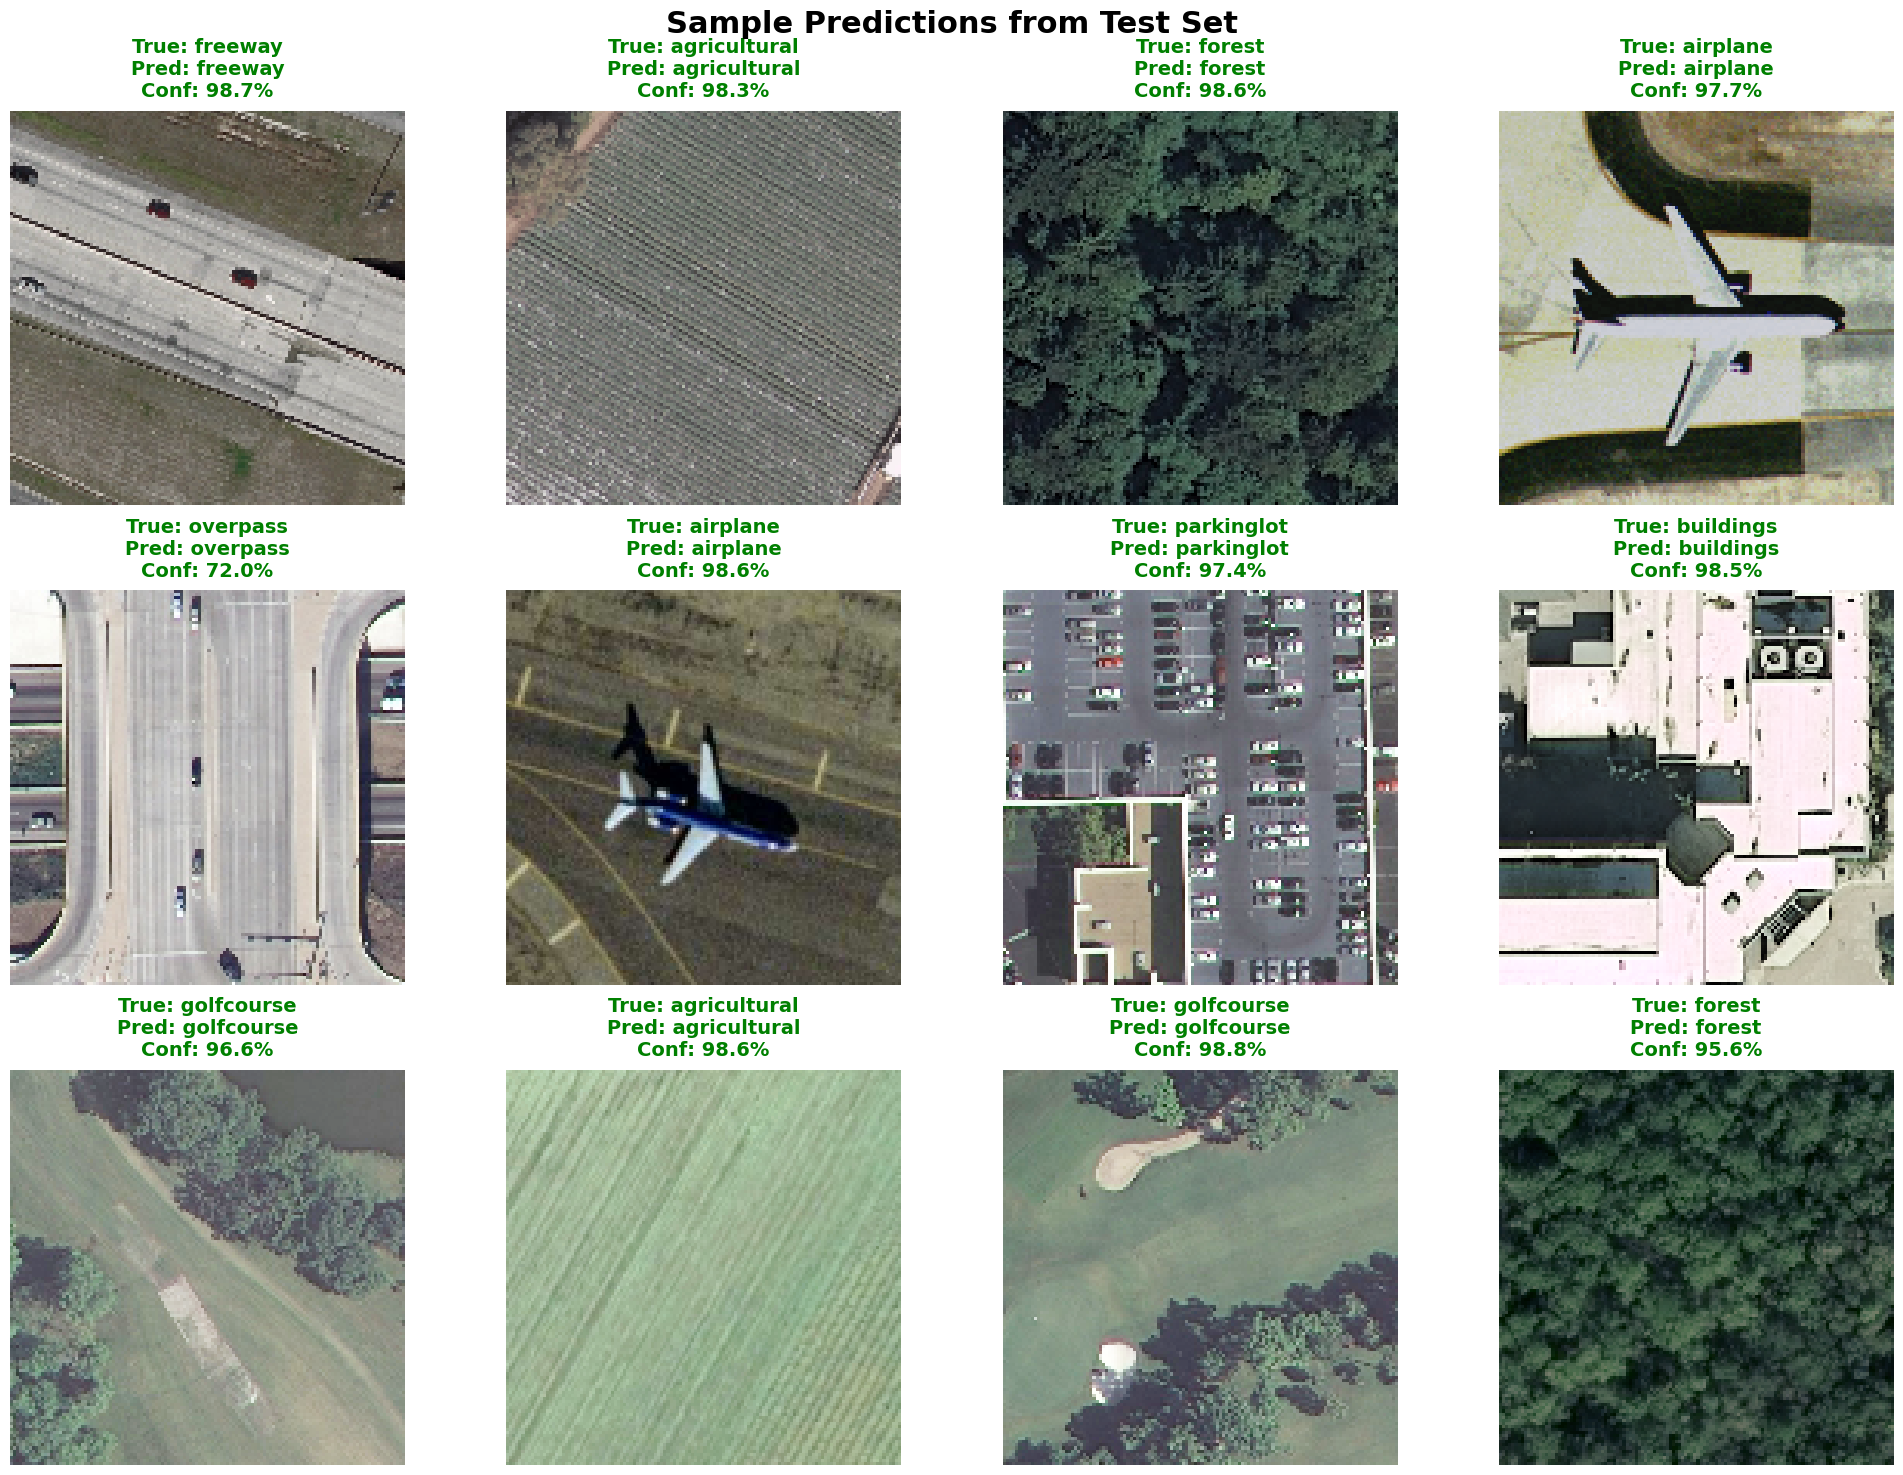


🔹 Visualizing correct predictions...


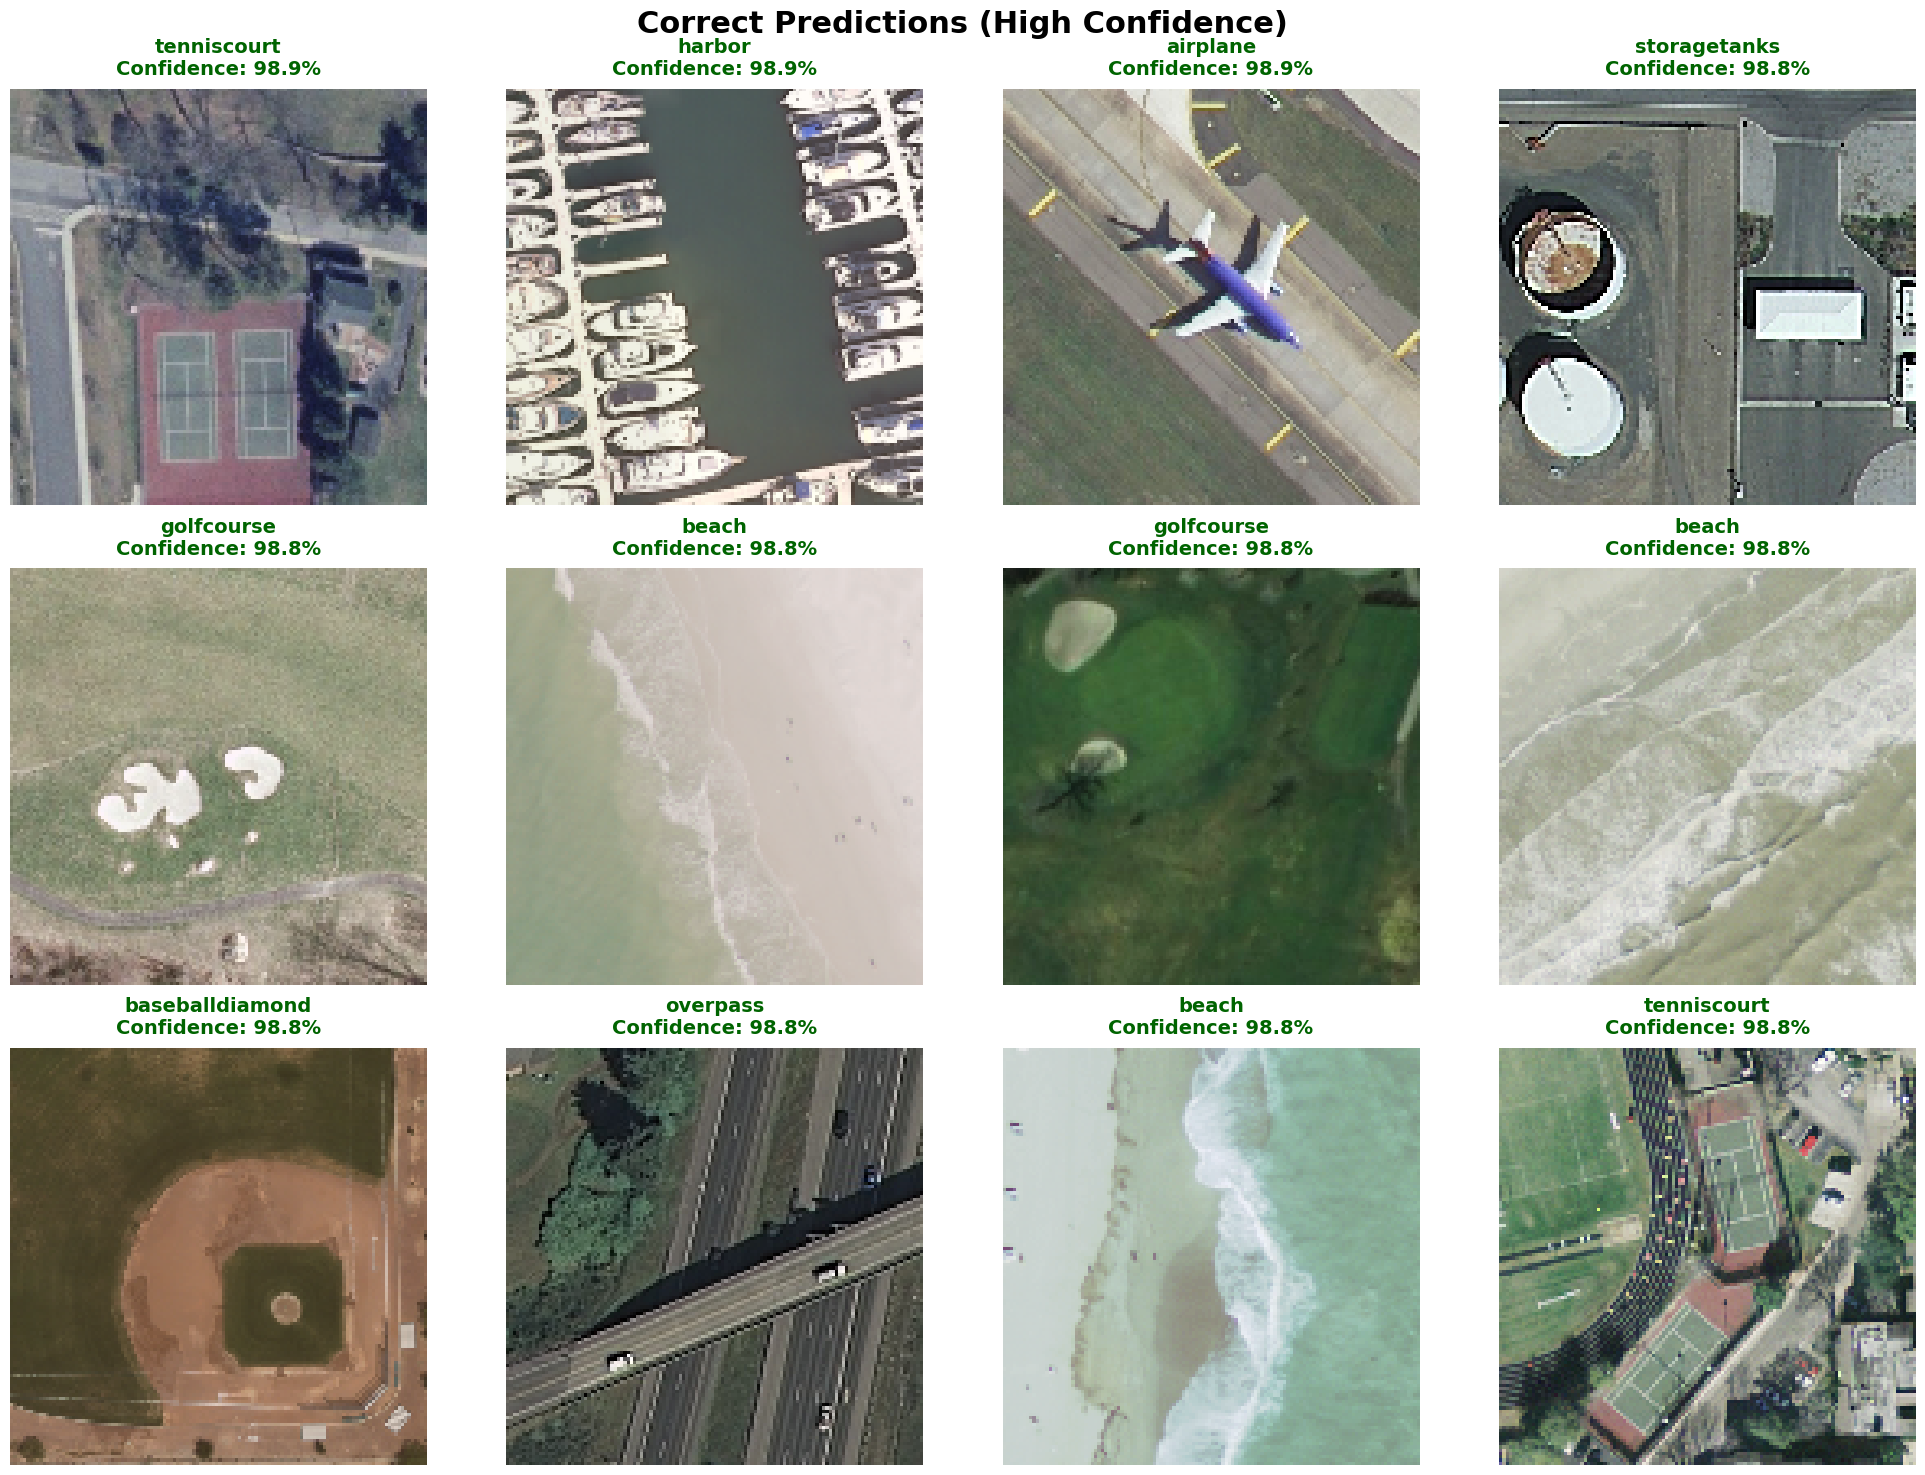


🔹 Visualizing incorrect predictions...


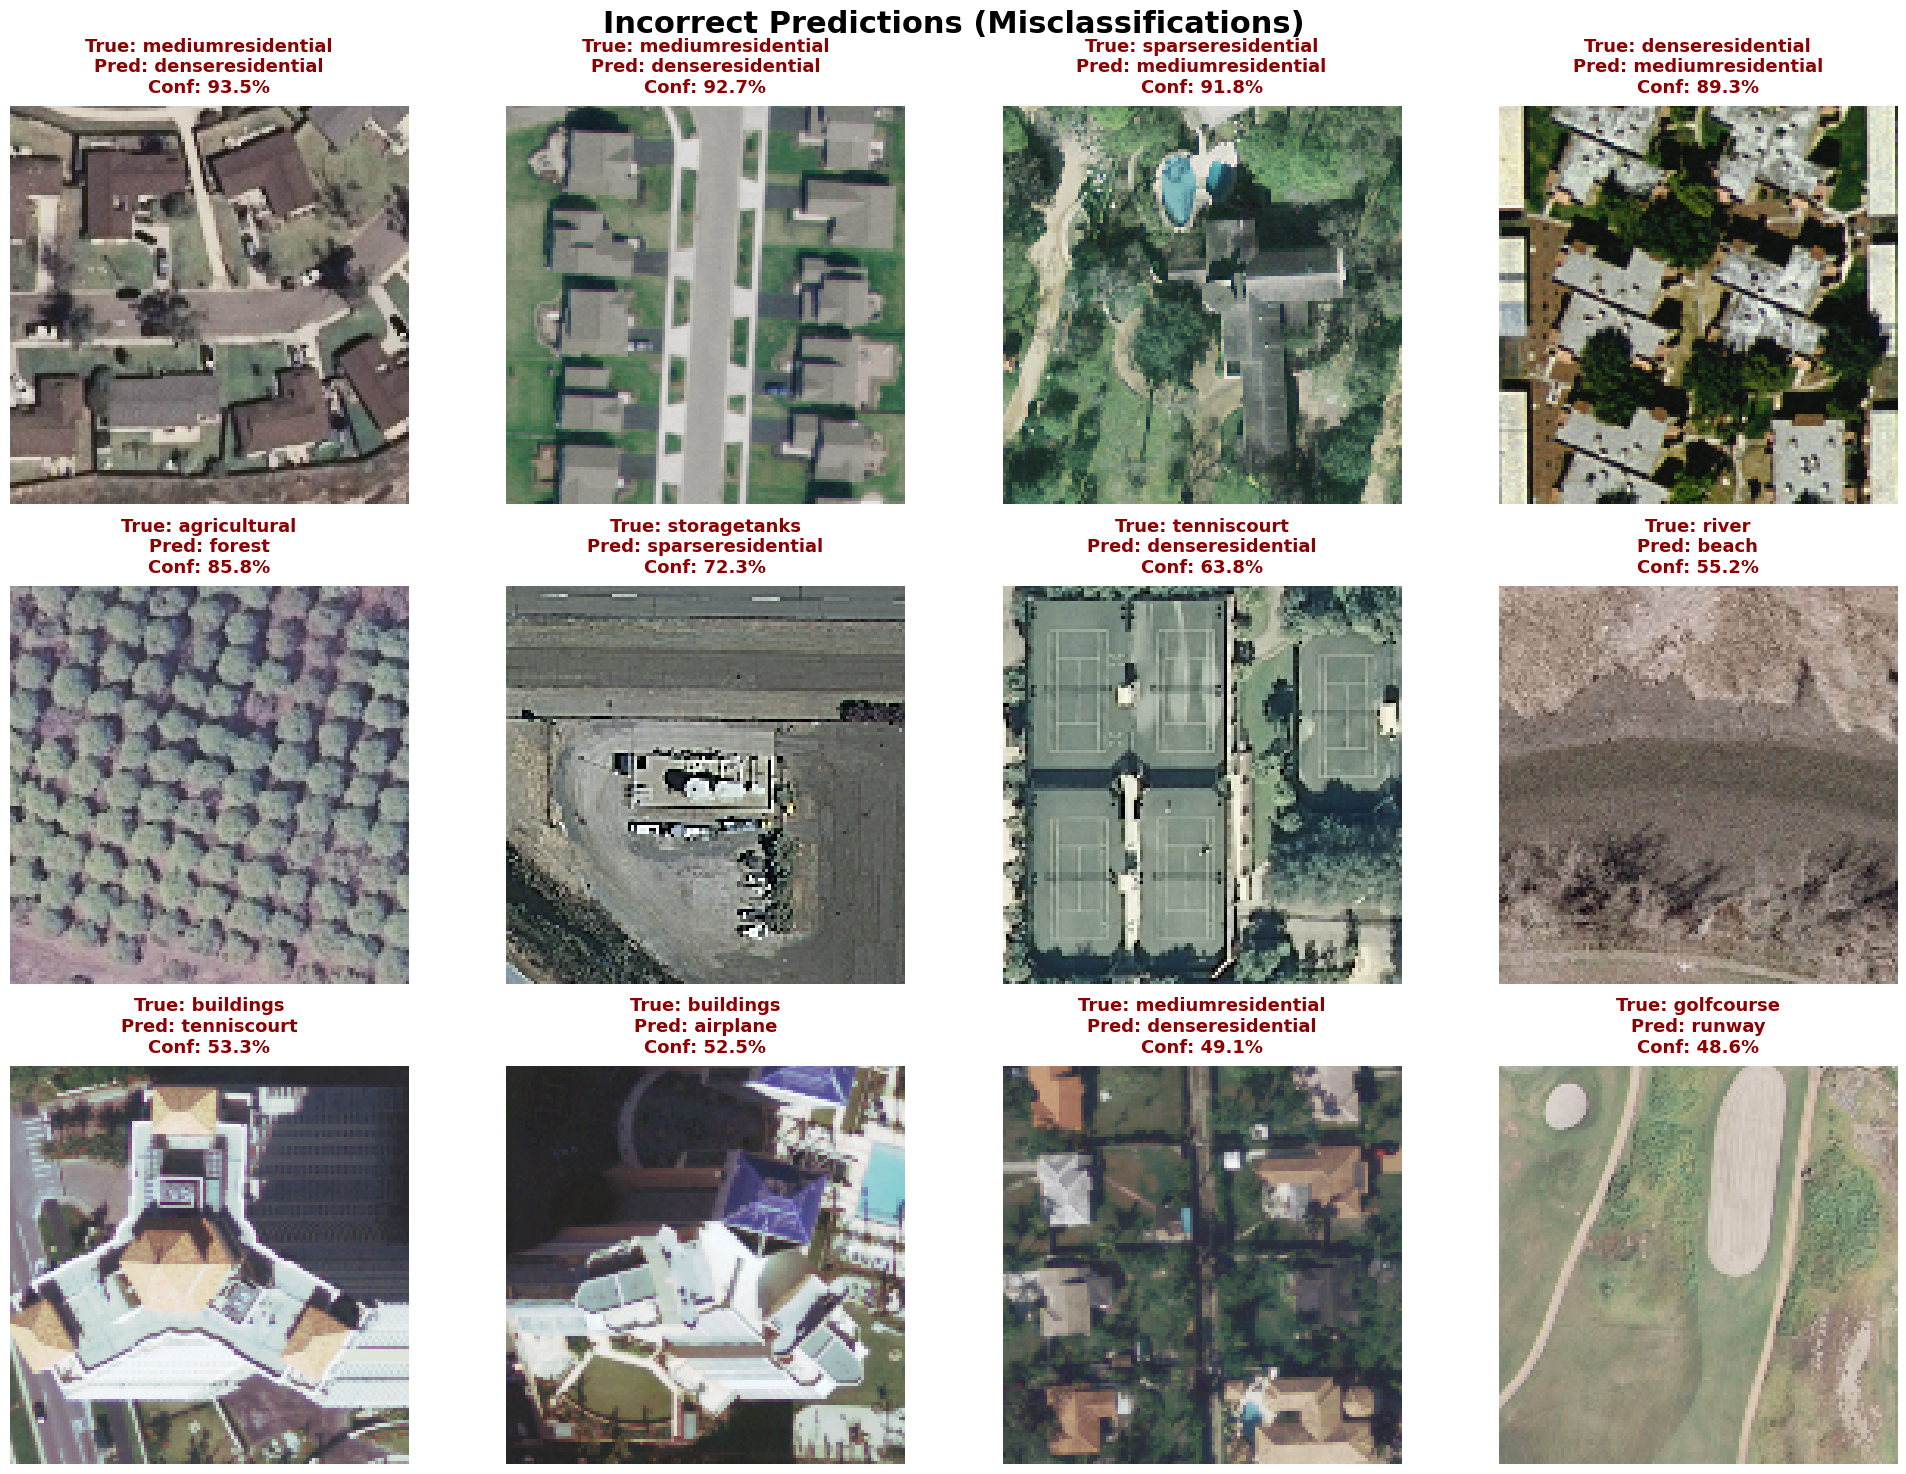

In [10]:
# ===============================
# QUALITATIVE VISUALIZATIONS - PUBLICATION QUALITY
# ===============================

# ===============================
# 1. Sample predictions from test set - LARGE CLEAR TEXT
# ===============================
def visualize_sample_predictions(X_test, y_test, y_pred, label_encoder, num_samples=12):
    """Display random test samples with predictions and confidence - CLEAR FOR PAPER"""
    indices = np.random.choice(len(X_test), min(num_samples, len(X_test)), replace=False)

    rows = 3
    cols = 4
    fig, axes = plt.subplots(rows, cols, figsize=(20, 15))
    axes = axes.ravel()

    for idx, i in enumerate(indices):
        if idx >= len(axes):
            break

        true_class = label_encoder.inverse_transform([np.argmax(y_test[i])])[0]
        pred_class = label_encoder.inverse_transform([np.argmax(y_pred[i])])[0]
        confidence = np.max(y_pred[i]) * 100

        axes[idx].imshow(X_test[i])
        axes[idx].axis('off')

        # Color code: green for correct, red for incorrect
        color = 'green' if true_class == pred_class else 'red'

        title = f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.1f}%'
        axes[idx].set_title(title, fontsize=14, color=color, fontweight='bold', pad=10)

    plt.suptitle('Sample Predictions from Test Set', fontsize=22, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

print("\n🔹 Visualizing sample predictions...")
visualize_sample_predictions(X_test, y_test, y_pred, label_encoder, num_samples=12)

# ===============================
# 2. Correct predictions showcase - LARGE CLEAR TEXT
# ===============================
def visualize_correct_predictions(X_test, y_test, y_pred, label_encoder, num_samples=12):
    """Display correctly classified samples with high confidence - CLEAR FOR PAPER"""
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Find correct predictions
    correct_mask = y_pred_classes == y_true_classes
    correct_indices = np.where(correct_mask)[0]

    # Sort by confidence (descending)
    confidences = np.max(y_pred[correct_indices], axis=1)
    sorted_indices = correct_indices[np.argsort(-confidences)]

    # Select top confident correct predictions
    display_indices = sorted_indices[:num_samples]

    rows = 3
    cols = 4
    fig, axes = plt.subplots(rows, cols, figsize=(20, 15))
    axes = axes.ravel()

    for idx, i in enumerate(display_indices):
        if idx >= len(axes):
            break

        true_class = label_encoder.inverse_transform([y_true_classes[i]])[0]
        confidence = np.max(y_pred[i]) * 100

        axes[idx].imshow(X_test[i])
        axes[idx].axis('off')
        axes[idx].set_title(f'{true_class}\nConfidence: {confidence:.1f}%',
                           fontsize=14, color='darkgreen', fontweight='bold', pad=10)

    plt.suptitle('Correct Predictions (High Confidence)', fontsize=22, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.savefig('correct_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

print("\n🔹 Visualizing correct predictions...")
visualize_correct_predictions(X_test, y_test, y_pred, label_encoder, num_samples=12)

# ===============================
# 3. Incorrect predictions analysis - LARGE CLEAR TEXT
# ===============================
def visualize_incorrect_predictions(X_test, y_test, y_pred, label_encoder, num_samples=12):
    """Display misclassified samples with analysis - CLEAR FOR PAPER"""
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Find incorrect predictions
    incorrect_mask = y_pred_classes != y_true_classes
    incorrect_indices = np.where(incorrect_mask)[0]

    if len(incorrect_indices) == 0:
        print("No incorrect predictions found!")
        return

    # Sort by confidence (to see confident mistakes)
    confidences = np.max(y_pred[incorrect_indices], axis=1)
    sorted_indices = incorrect_indices[np.argsort(-confidences)]

    display_indices = sorted_indices[:num_samples]

    rows = 3
    cols = 4
    fig, axes = plt.subplots(rows, cols, figsize=(20, 15))
    axes = axes.ravel()

    for idx, i in enumerate(display_indices):
        if idx >= len(axes):
            break

        true_class = label_encoder.inverse_transform([y_true_classes[i]])[0]
        pred_class = label_encoder.inverse_transform([y_pred_classes[i]])[0]
        confidence = np.max(y_pred[i]) * 100

        axes[idx].imshow(X_test[i])
        axes[idx].axis('off')
        title = f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.1f}%'
        axes[idx].set_title(title, fontsize=13, color='darkred', fontweight='bold', pad=10)

    plt.suptitle('Incorrect Predictions (Misclassifications)', fontsize=22, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.savefig('incorrect_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

print("\n🔹 Visualizing incorrect predictions...")
visualize_incorrect_predictions(X_test, y_test, y_pred, label_encoder, num_samples=12)



🔹 Visualizing uncertain predictions...


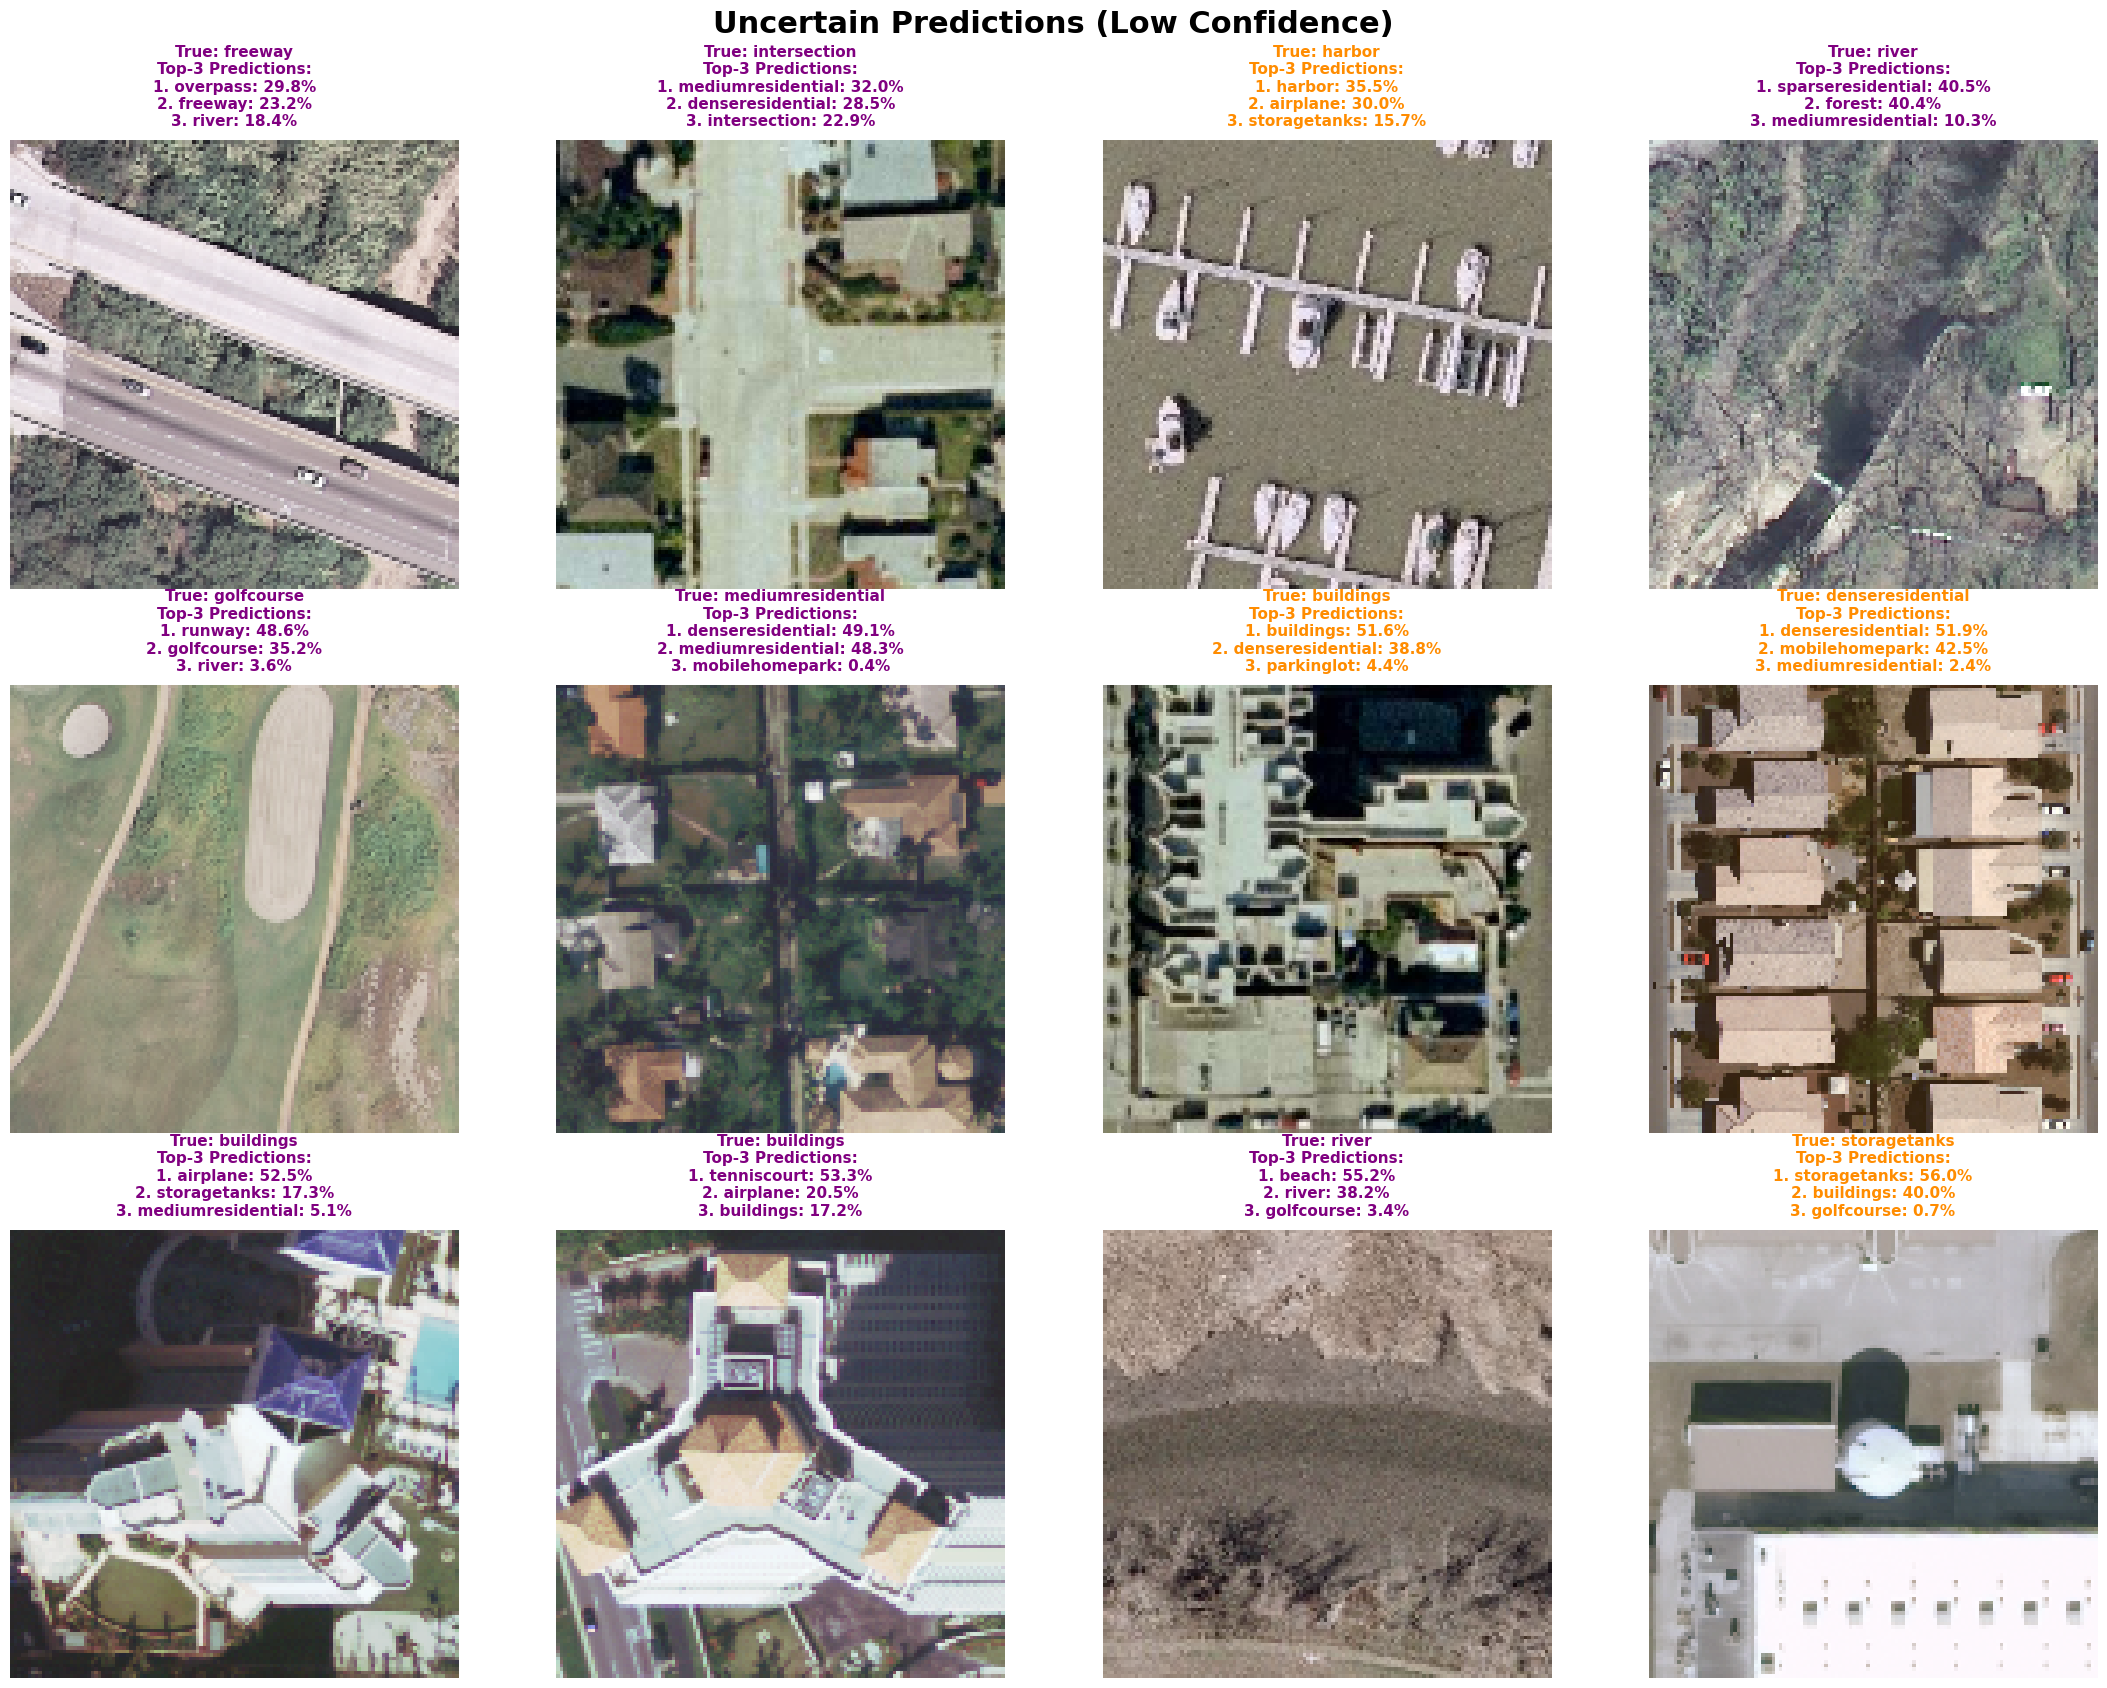

In [11]:
# ===============================
# 4. Uncertainty analysis (low confidence predictions) - LARGE CLEAR TEXT
# ===============================
def visualize_uncertain_predictions(X_test, y_test, y_pred, label_encoder, num_samples=12):
    """Display predictions with low confidence (uncertain classifications) - CLEAR FOR PAPER"""
    confidences = np.max(y_pred, axis=1)

    # Find low confidence predictions
    uncertain_indices = np.argsort(confidences)[:num_samples]

    rows = 3
    cols = 4
    fig, axes = plt.subplots(rows, cols, figsize=(22, 17))
    axes = axes.ravel()

    for idx, i in enumerate(uncertain_indices):
        if idx >= len(axes):
            break

        true_class = label_encoder.inverse_transform([np.argmax(y_test[i])])[0]
        pred_class = label_encoder.inverse_transform([np.argmax(y_pred[i])])[0]
        confidence = np.max(y_pred[i]) * 100

        # Get top 3 predictions
        top3_indices = np.argsort(y_pred[i])[-3:][::-1]
        top3_classes = label_encoder.inverse_transform(top3_indices)
        top3_probs = y_pred[i][top3_indices] * 100

        axes[idx].imshow(X_test[i])
        axes[idx].axis('off')

        # Color code
        color = 'darkorange' if true_class == pred_class else 'purple'

        title = f'True: {true_class}\nTop-3 Predictions:\n'
        for j in range(3):
            title += f'{j+1}. {top3_classes[j]}: {top3_probs[j]:.1f}%\n'

        axes[idx].set_title(title.strip(), fontsize=11, color=color, fontweight='bold', pad=10)

    plt.suptitle('Uncertain Predictions (Low Confidence)', fontsize=22, fontweight='bold', y=0.99)
    plt.tight_layout()
    plt.savefig('uncertain_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

print("\n🔹 Visualizing uncertain predictions...")
visualize_uncertain_predictions(X_test, y_test, y_pred, label_encoder, num_samples=12)



🔹 Analyzing confidence distribution...


/tmp/ipython-input-2925638721.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1].boxplot(data_to_plot, labels=['Correct', 'Incorrect'], patch_artist=True, widths=0.6)


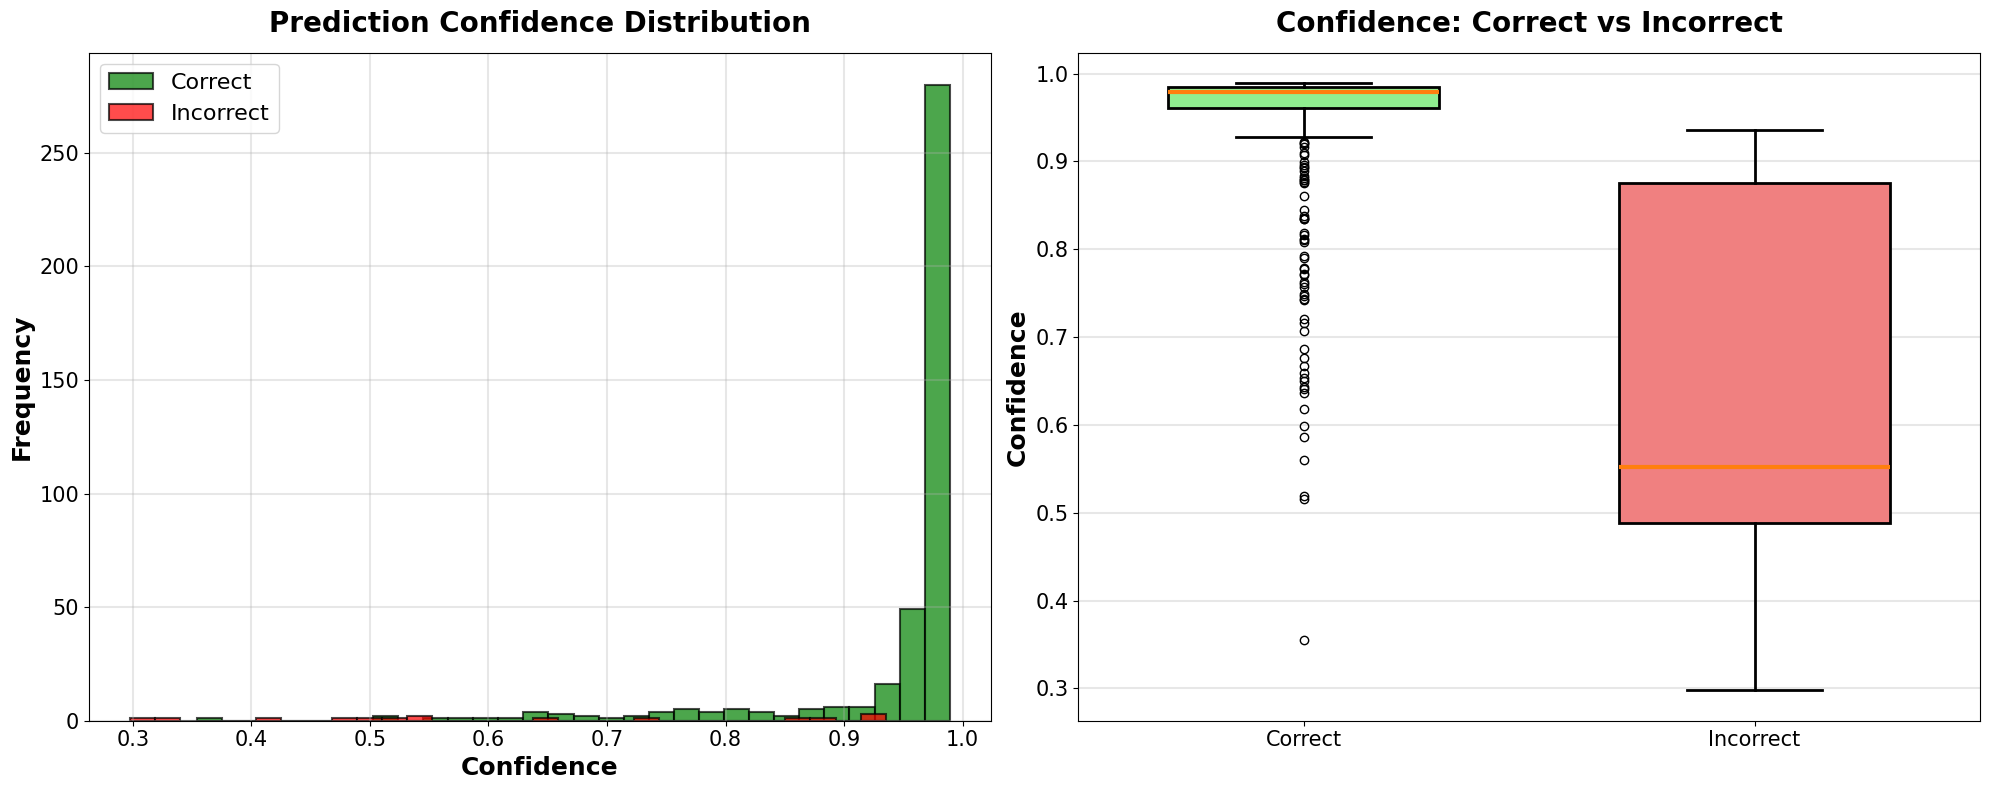


📊 Confidence Statistics:
Correct predictions - Mean: 0.9455, Std: 0.0881
Incorrect predictions - Mean: 0.6335, Std: 0.2186

🔹 Visualizing per-class performance...


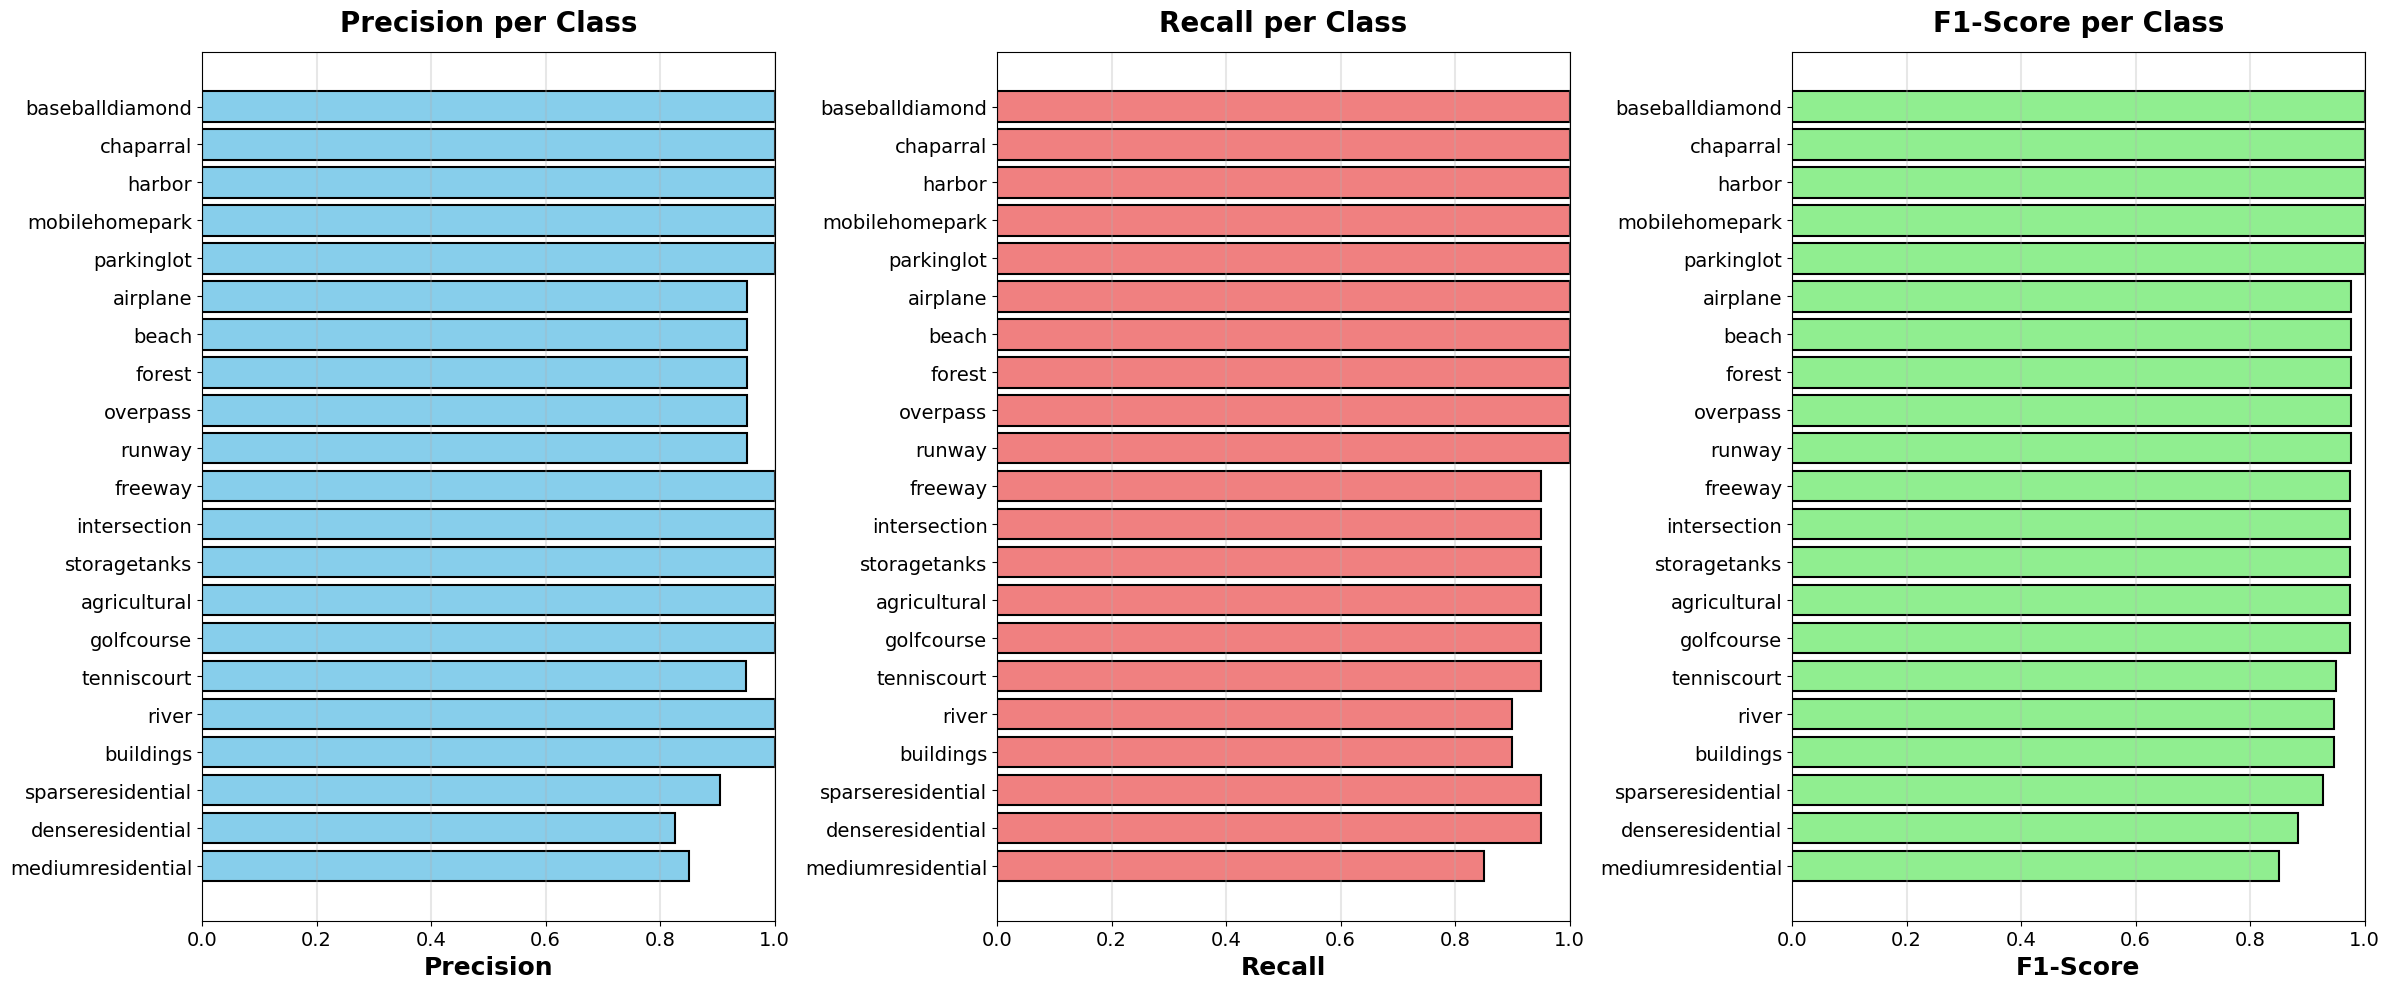

In [12]:
# ===============================
# 5. Prediction confidence distribution - HIGH QUALITY
# ===============================
def visualize_confidence_distribution(y_pred, y_test):
    """Show distribution of prediction confidence for correct vs incorrect - CLEAR FOR PAPER"""
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    confidences = np.max(y_pred, axis=1)

    correct_mask = y_pred_classes == y_true_classes
    correct_confidences = confidences[correct_mask]
    incorrect_confidences = confidences[~correct_mask]

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Histogram
    axes[0].hist(correct_confidences, bins=30, alpha=0.7, label='Correct', color='green', edgecolor='black', linewidth=1.5)
    axes[0].hist(incorrect_confidences, bins=30, alpha=0.7, label='Incorrect', color='red', edgecolor='black', linewidth=1.5)
    axes[0].set_xlabel('Confidence', fontsize=18, fontweight='bold')
    axes[0].set_ylabel('Frequency', fontsize=18, fontweight='bold')
    axes[0].set_title('Prediction Confidence Distribution', fontsize=20, fontweight='bold', pad=15)
    axes[0].legend(fontsize=16)
    axes[0].grid(True, alpha=0.3, linewidth=1.5)
    axes[0].tick_params(labelsize=15)

    # Box plot
    data_to_plot = [correct_confidences, incorrect_confidences]
    bp = axes[1].boxplot(data_to_plot, labels=['Correct', 'Incorrect'], patch_artist=True, widths=0.6)
    bp['boxes'][0].set_facecolor('lightgreen')
    bp['boxes'][1].set_facecolor('lightcoral')
    for box in bp['boxes']:
        box.set_linewidth(2)
    for whisker in bp['whiskers']:
        whisker.set_linewidth(2)
    for cap in bp['caps']:
        cap.set_linewidth(2)
    for median in bp['medians']:
        median.set_linewidth(3)

    axes[1].set_ylabel('Confidence', fontsize=18, fontweight='bold')
    axes[1].set_title('Confidence: Correct vs Incorrect', fontsize=20, fontweight='bold', pad=15)
    axes[1].grid(True, alpha=0.3, axis='y', linewidth=1.5)
    axes[1].tick_params(labelsize=15)

    plt.tight_layout()
    plt.savefig('confidence_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\n📊 Confidence Statistics:")
    print(f"Correct predictions - Mean: {np.mean(correct_confidences):.4f}, Std: {np.std(correct_confidences):.4f}")
    print(f"Incorrect predictions - Mean: {np.mean(incorrect_confidences):.4f}, Std: {np.std(incorrect_confidences):.4f}")

print("\n🔹 Analyzing confidence distribution...")
visualize_confidence_distribution(y_pred, y_test)

# ===============================
# 6. Per-class performance visualization - HIGH QUALITY
# ===============================
def visualize_per_class_performance(y_test, y_pred, label_encoder):
    """Show performance metrics for each class - CLEAR FOR PAPER"""
    from sklearn.metrics import precision_score, recall_score, f1_score

    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Calculate per-class metrics
    precision_per_class = precision_score(y_true_classes, y_pred_classes, average=None, zero_division=0)
    recall_per_class = recall_score(y_true_classes, y_pred_classes, average=None, zero_division=0)
    f1_per_class = f1_score(y_true_classes, y_pred_classes, average=None, zero_division=0)

    class_names = label_encoder.classes_

    # Create DataFrame
    df_metrics = pd.DataFrame({
        'Class': class_names,
        'Precision': precision_per_class,
        'Recall': recall_per_class,
        'F1-Score': f1_per_class
    })

    # Sort by F1-Score
    df_metrics = df_metrics.sort_values('F1-Score', ascending=True)

    fig, axes = plt.subplots(1, 3, figsize=(24, 10))

    # Precision
    axes[0].barh(df_metrics['Class'], df_metrics['Precision'], color='skyblue', edgecolor='black', linewidth=1.5)
    axes[0].set_xlabel('Precision', fontsize=18, fontweight='bold')
    axes[0].set_title('Precision per Class', fontsize=20, fontweight='bold', pad=15)
    axes[0].set_xlim([0, 1])
    axes[0].grid(True, alpha=0.3, axis='x', linewidth=1.5)
    axes[0].tick_params(labelsize=14)

    # Recall
    axes[1].barh(df_metrics['Class'], df_metrics['Recall'], color='lightcoral', edgecolor='black', linewidth=1.5)
    axes[1].set_xlabel('Recall', fontsize=18, fontweight='bold')
    axes[1].set_title('Recall per Class', fontsize=20, fontweight='bold', pad=15)
    axes[1].set_xlim([0, 1])
    axes[1].grid(True, alpha=0.3, axis='x', linewidth=1.5)
    axes[1].tick_params(labelsize=14)

    # F1-Score
    axes[2].barh(df_metrics['Class'], df_metrics['F1-Score'], color='lightgreen', edgecolor='black', linewidth=1.5)
    axes[2].set_xlabel('F1-Score', fontsize=18, fontweight='bold')
    axes[2].set_title('F1-Score per Class', fontsize=20, fontweight='bold', pad=15)
    axes[2].set_xlim([0, 1])
    axes[2].grid(True, alpha=0.3, axis='x', linewidth=1.5)
    axes[2].tick_params(labelsize=14)

    plt.tight_layout()
    plt.savefig('per_class_performance.png', dpi=300, bbox_inches='tight')
    plt.show()

print("\n🔹 Visualizing per-class performance...")
visualize_per_class_performance(y_test, y_pred, label_encoder)



🔹 Analyzing entropy-based uncertainty...


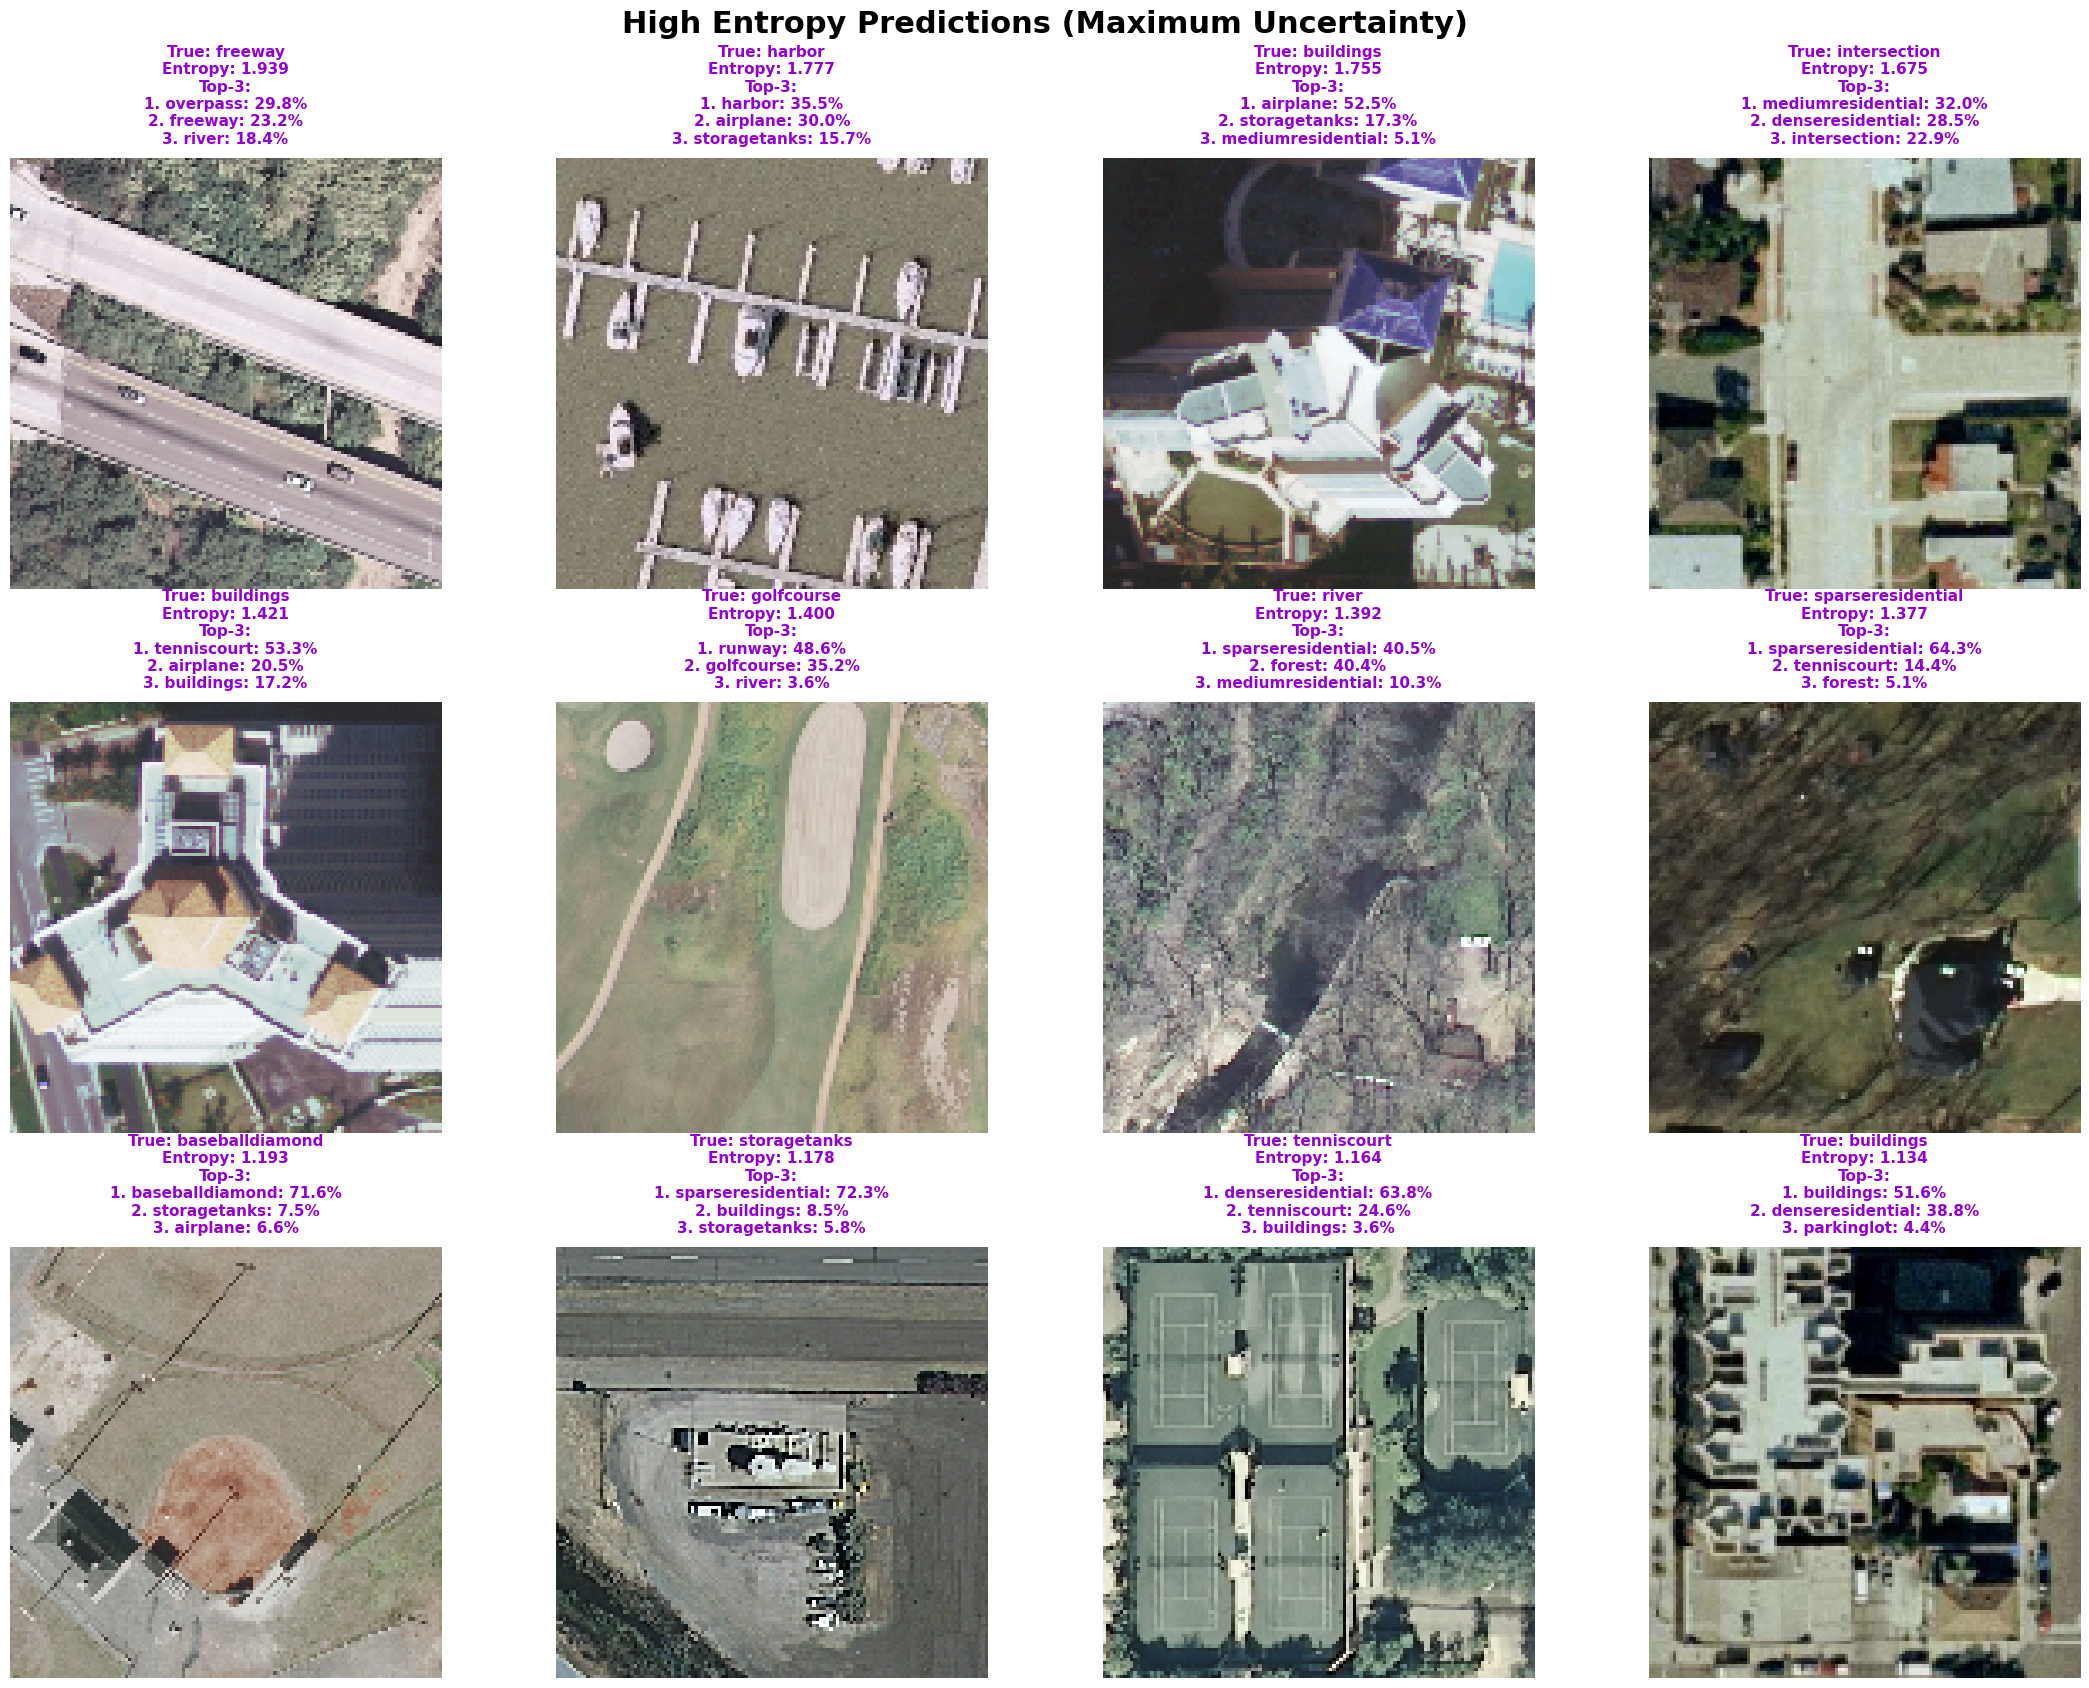

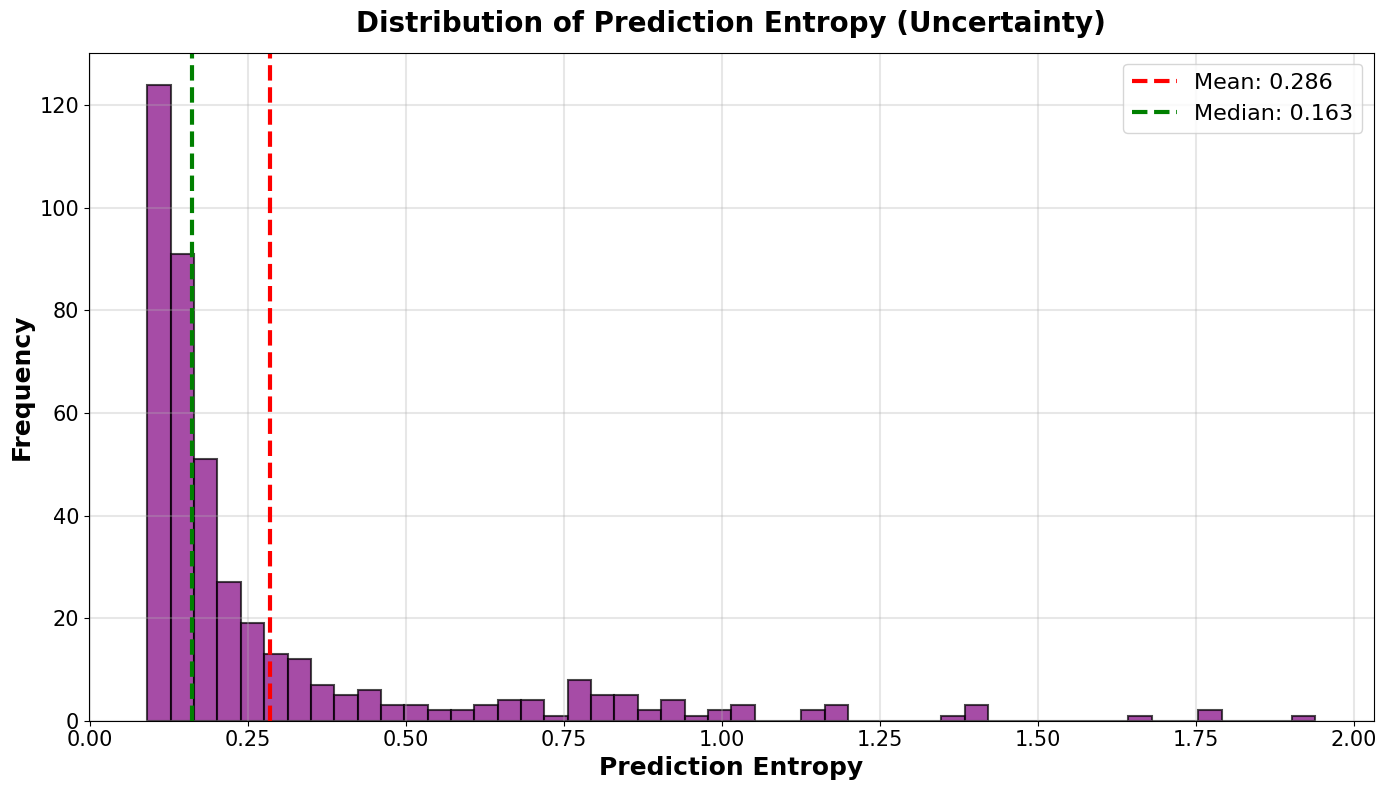

In [13]:

# ===============================
# 7. Entropy-based uncertainty visualization - HIGH QUALITY
# ===============================
def calculate_entropy(predictions):
    """Calculate prediction entropy (uncertainty measure)"""
    epsilon = 1e-10
    return -np.sum(predictions * np.log(predictions + epsilon), axis=1)

def visualize_entropy_uncertainty(X_test, y_test, y_pred, label_encoder, num_samples=12):
    """Visualize samples based on prediction entropy - CLEAR FOR PAPER"""
    entropy = calculate_entropy(y_pred)

    # Find high entropy (most uncertain) samples
    high_entropy_indices = np.argsort(-entropy)[:num_samples]

    rows = 3
    cols = 4
    fig, axes = plt.subplots(rows, cols, figsize=(22, 17))
    axes = axes.ravel()

    for idx, i in enumerate(high_entropy_indices):
        if idx >= len(axes):
            break

        true_class = label_encoder.inverse_transform([np.argmax(y_test[i])])[0]

        # Get top 3 predictions
        top3_indices = np.argsort(y_pred[i])[-3:][::-1]
        top3_classes = label_encoder.inverse_transform(top3_indices)
        top3_probs = y_pred[i][top3_indices] * 100

        axes[idx].imshow(X_test[i])
        axes[idx].axis('off')

        title = f'True: {true_class}\nEntropy: {entropy[i]:.3f}\nTop-3:\n'
        for j in range(3):
            title += f'{j+1}. {top3_classes[j]}: {top3_probs[j]:.1f}%\n'

        axes[idx].set_title(title.strip(), fontsize=11, color='darkviolet', fontweight='bold', pad=10)

    plt.suptitle('High Entropy Predictions (Maximum Uncertainty)', fontsize=22, fontweight='bold', y=0.99)
    plt.tight_layout()
    plt.savefig('entropy_uncertainty.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Entropy distribution
    plt.figure(figsize=(14, 8))
    plt.hist(entropy, bins=50, color='purple', alpha=0.7, edgecolor='black', linewidth=1.5)
    plt.axvline(np.mean(entropy), color='red', linestyle='--', linewidth=3, label=f'Mean: {np.mean(entropy):.3f}')
    plt.axvline(np.median(entropy), color='green', linestyle='--', linewidth=3, label=f'Median: {np.median(entropy):.3f}')
    plt.xlabel('Prediction Entropy', fontsize=18, fontweight='bold')
    plt.ylabel('Frequency', fontsize=18, fontweight='bold')
    plt.title('Distribution of Prediction Entropy (Uncertainty)', fontsize=20, fontweight='bold', pad=15)
    plt.legend(fontsize=16)
    plt.grid(True, alpha=0.3, linewidth=1.5)
    plt.tick_params(labelsize=15)
    plt.tight_layout()
    plt.savefig('entropy_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

print("\n🔹 Analyzing entropy-based uncertainty...")
visualize_entropy_uncertainty(X_test, y_test, y_pred, label_encoder, num_samples=12)



🔹 Visualizing fuzzy membership for interpretability...


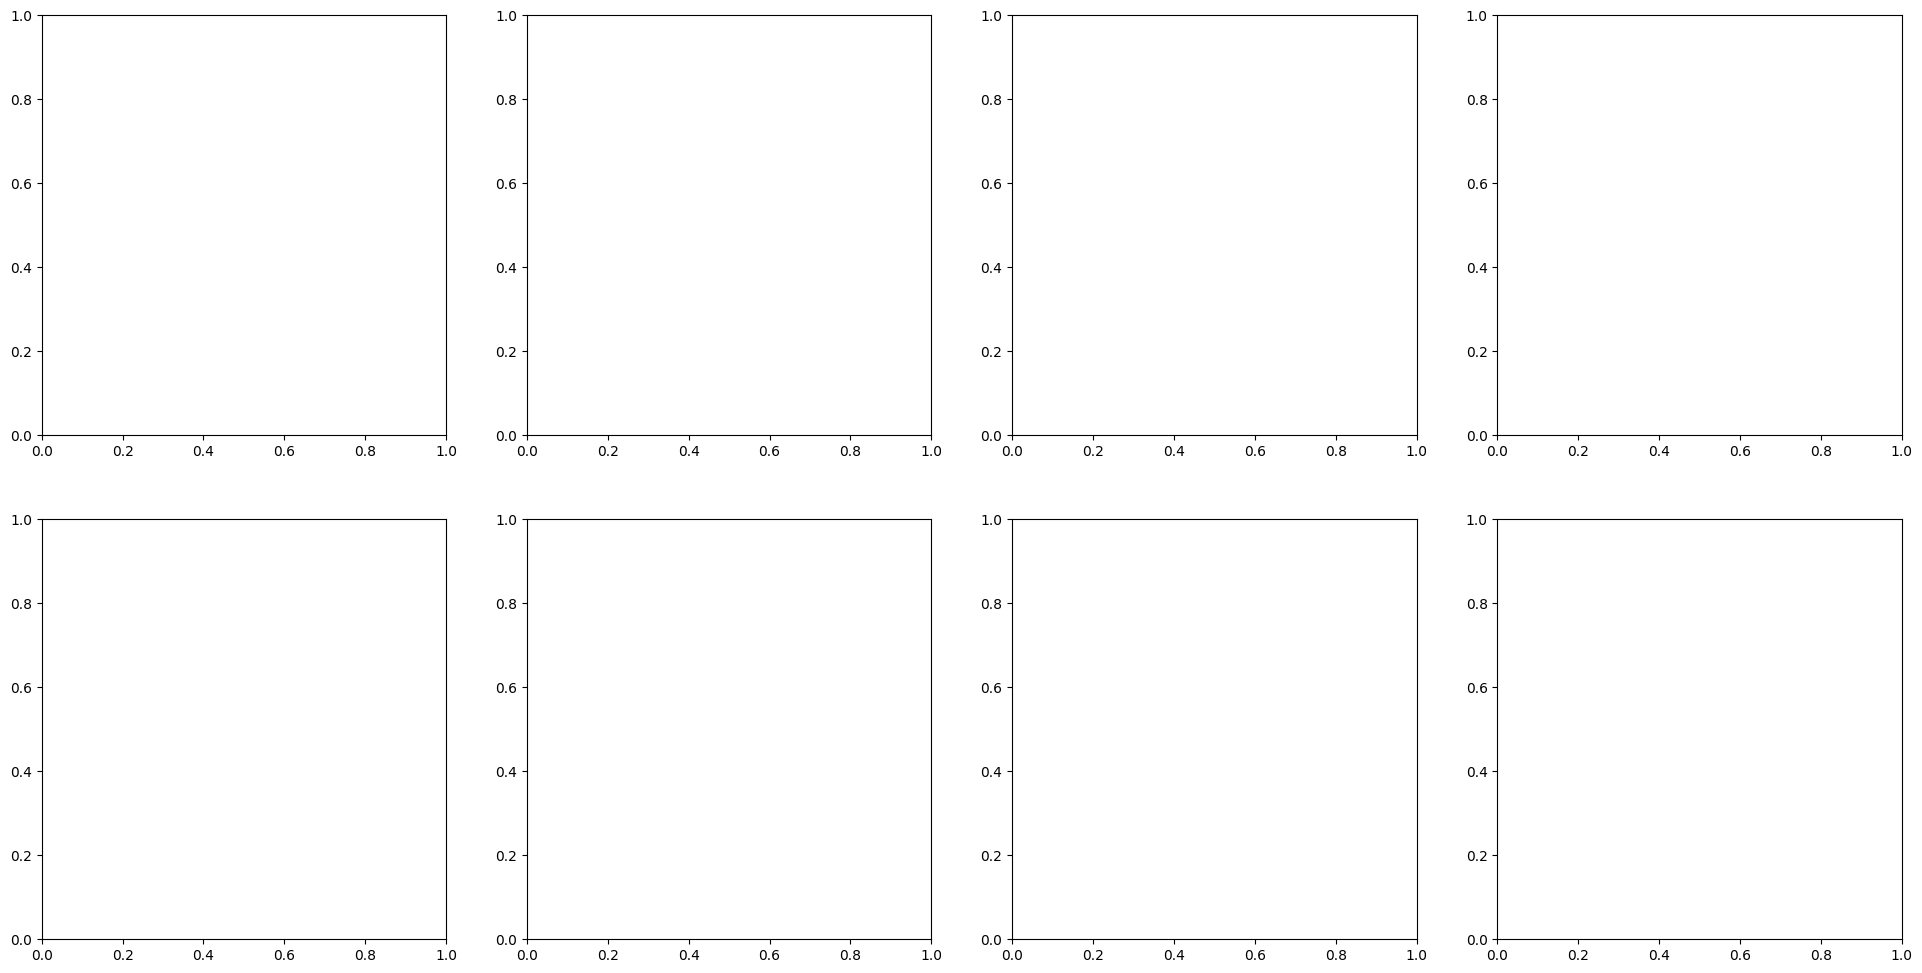

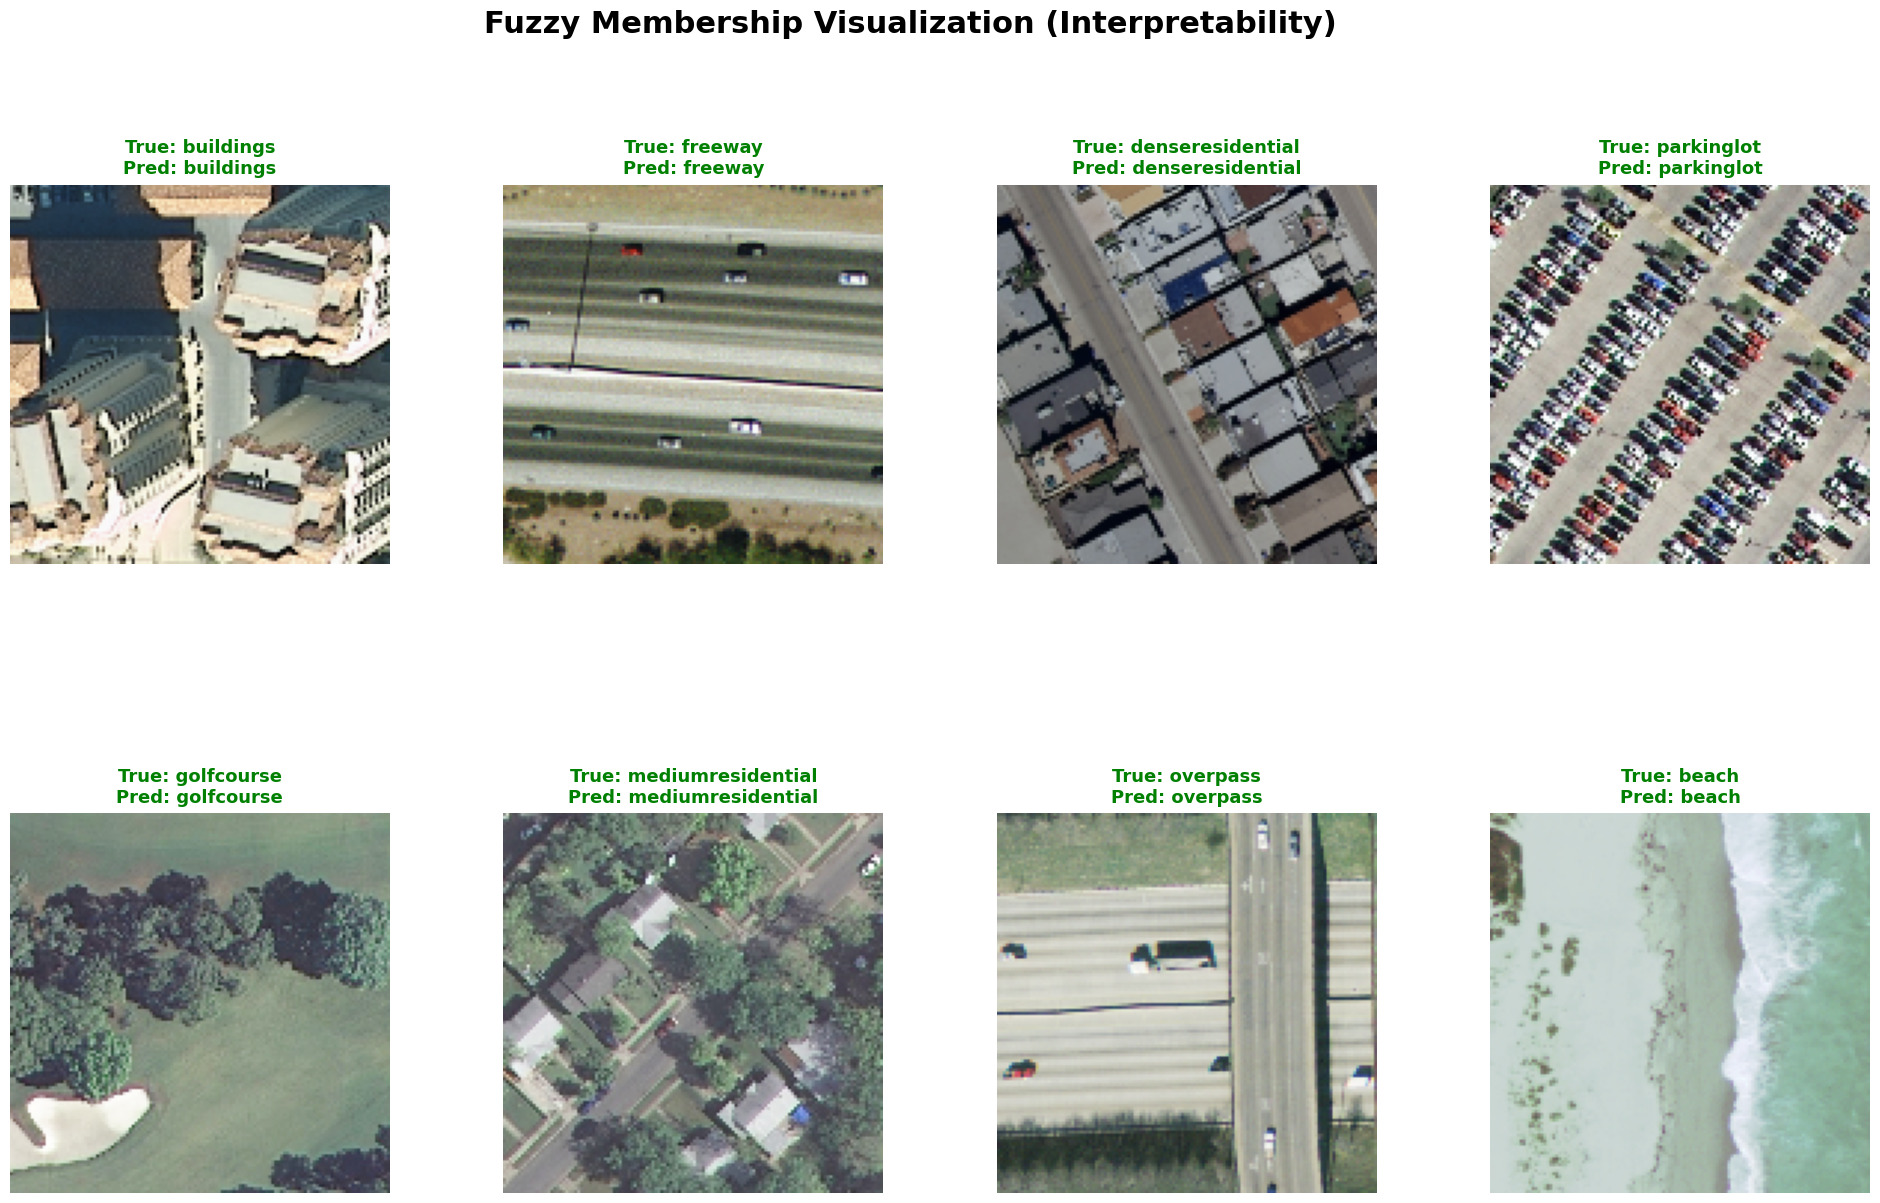

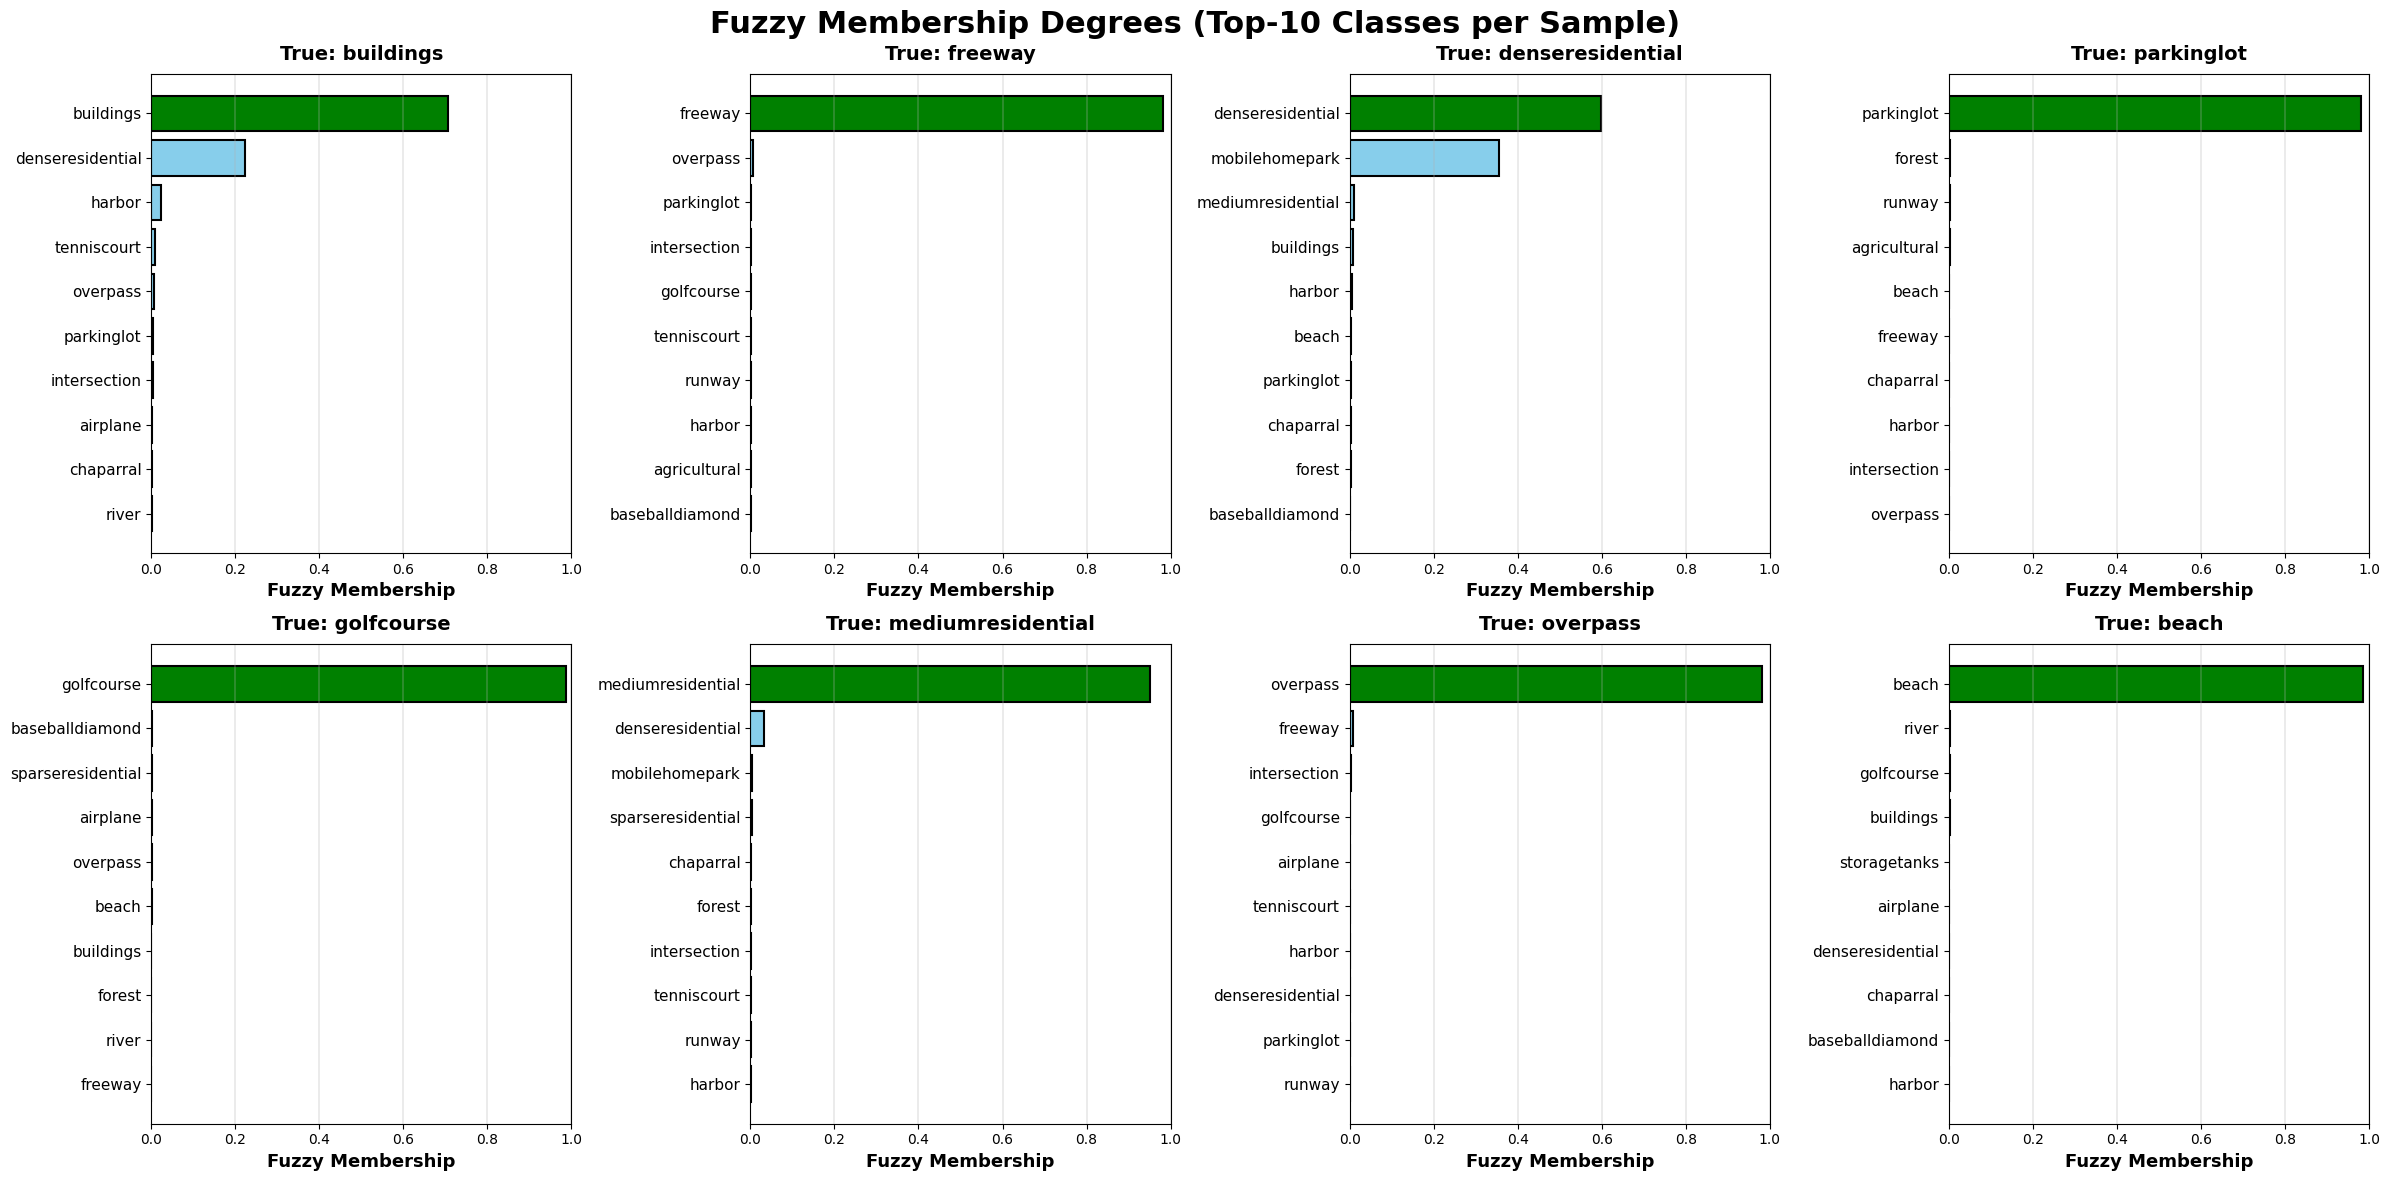

In [14]:
# ===============================
# 8. Fuzzy membership visualization - INTERPRETABILITY
# ===============================
def visualize_fuzzy_membership(X_test, y_test, y_pred, label_encoder, num_samples=8):
    """Visualize fuzzy membership degrees for interpretability - CLEAR FOR PAPER"""
    indices = np.random.choice(len(X_test), min(num_samples, len(X_test)), replace=False)

    rows = 2
    cols = 4
    fig, axes = plt.subplots(rows, cols, figsize=(24, 12))
    axes = axes.ravel()

    for idx, i in enumerate(indices):
        if idx >= len(axes):
            break

        # Get fuzzy membership values (predictions)
        membership_values = y_pred[i]
        true_class = label_encoder.inverse_transform([np.argmax(y_test[i])])[0]
        pred_class = label_encoder.inverse_transform([np.argmax(y_pred[i])])[0]

        # Create subplot with image and membership bar chart
        # Split into image and bar chart
        ax = axes[idx]

        # Display image on top half
        from matplotlib.gridspec import GridSpec

    # Better approach: create figure with subplots for each sample
    fig = plt.figure(figsize=(24, 14))
    gs = fig.add_gridspec(2, 4, hspace=0.4, wspace=0.3)

    for idx, i in enumerate(indices[:8]):
        # Create a subplot for image and bars
        ax_img = fig.add_subplot(gs[idx // 4, idx % 4])

        membership_values = y_pred[i]
        true_class = label_encoder.inverse_transform([np.argmax(y_test[i])])[0]
        pred_class = label_encoder.inverse_transform([np.argmax(y_pred[i])])[0]

        # Show image
        ax_img.imshow(X_test[i])
        ax_img.axis('off')

        color = 'green' if true_class == pred_class else 'red'
        ax_img.set_title(f'True: {true_class}\nPred: {pred_class}',
                        fontsize=13, color=color, fontweight='bold', pad=8)

    plt.suptitle('Fuzzy Membership Visualization (Interpretability)', fontsize=22, fontweight='bold')
    plt.savefig('fuzzy_membership_samples.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Also create membership distribution plots for selected samples
    fig, axes = plt.subplots(2, 4, figsize=(24, 12))
    axes = axes.ravel()

    for idx, i in enumerate(indices[:8]):
        membership_values = y_pred[i]
        true_class = label_encoder.inverse_transform([np.argmax(y_test[i])])[0]

        # Get top 10 memberships
        top_indices = np.argsort(-membership_values)[:10]
        top_classes = label_encoder.inverse_transform(top_indices)
        top_memberships = membership_values[top_indices]

        # Color bars based on true class
        colors = ['green' if c == true_class else 'skyblue' for c in top_classes]

        axes[idx].barh(range(len(top_classes)), top_memberships, color=colors, edgecolor='black', linewidth=1.5)
        axes[idx].set_yticks(range(len(top_classes)))
        axes[idx].set_yticklabels(top_classes, fontsize=11)
        axes[idx].set_xlabel('Fuzzy Membership', fontsize=13, fontweight='bold')
        axes[idx].set_title(f'True: {true_class}', fontsize=14, fontweight='bold', pad=10)
        axes[idx].set_xlim([0, 1])
        axes[idx].grid(True, alpha=0.3, axis='x', linewidth=1.2)
        axes[idx].invert_yaxis()

    plt.suptitle('Fuzzy Membership Degrees (Top-10 Classes per Sample)', fontsize=22, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.savefig('fuzzy_membership_bars.png', dpi=300, bbox_inches='tight')
    plt.show()

print("\n🔹 Visualizing fuzzy membership for interpretability...")
visualize_fuzzy_membership(X_test, y_test, y_pred, label_encoder, num_samples=8)


In [15]:
# ===============================
# Summary statistics
# ===============================
print("\n" + "="*80)
print("FINAL SUMMARY - UC MERCED LAND USE CLASSIFICATION")
print("="*80)

y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

accuracy = np.mean(y_pred_classes == y_true_classes)
print(f"\n✅ Overall Test Accuracy: {accuracy * 100:.2f}%")

correct_count = np.sum(y_pred_classes == y_true_classes)
incorrect_count = np.sum(y_pred_classes != y_true_classes)
print(f"✅ Correct Predictions: {correct_count}/{len(y_test)} ({correct_count/len(y_test)*100:.2f}%)")
print(f"❌ Incorrect Predictions: {incorrect_count}/{len(y_test)} ({incorrect_count/len(y_test)*100:.2f}%)")

confidences = np.max(y_pred, axis=1)
print(f"\n📊 Average Confidence: {np.mean(confidences)*100:.2f}%")
print(f"📊 Median Confidence: {np.median(confidences)*100:.2f}%")

high_conf_threshold = 0.9
high_conf_correct = np.sum((confidences > high_conf_threshold) & (y_pred_classes == y_true_classes))
high_conf_total = np.sum(confidences > high_conf_threshold)
print(f"\n🎯 High confidence (>90%) predictions: {high_conf_total}")
if high_conf_total > 0:
    print(f"🎯 High confidence correct: {high_conf_correct}/{high_conf_total} ({high_conf_correct/high_conf_total*100:.2f}%)")

print("\n" + "="*80)
print("All visualizations saved as high-resolution PNG files (300 DPI)")
print("Model saved as: best_ucmerced_fuzzy_model.h5")
print("="*80)
print("\nGenerated files for paper:")
print("  1. class_distribution.png")
print("  2. confusion_matrix.png")
print("  3. training_metrics.png")
print("  4. sample_predictions.png")
print("  5. correct_predictions.png")
print("  6. incorrect_predictions.png")
print("  7. uncertain_predictions.png")
print("  8. confidence_distribution.png")
print("  9. per_class_performance.png")
print(" 10. entropy_uncertainty.png")
print(" 11. entropy_distribution.png")
print(" 12. fuzzy_membership_samples.png")
print(" 13. fuzzy_membership_bars.png")
print("="*80)


FINAL SUMMARY - UC MERCED LAND USE CLASSIFICATION

✅ Overall Test Accuracy: 96.43%
✅ Correct Predictions: 405/420 (96.43%)
❌ Incorrect Predictions: 15/420 (3.57%)

📊 Average Confidence: 93.44%
📊 Median Confidence: 97.81%

🎯 High confidence (>90%) predictions: 354
🎯 High confidence correct: 351/354 (99.15%)

All visualizations saved as high-resolution PNG files (300 DPI)
Model saved as: best_ucmerced_fuzzy_model.h5

Generated files for paper:
  1. class_distribution.png
  2. confusion_matrix.png
  3. training_metrics.png
  4. sample_predictions.png
  5. correct_predictions.png
  6. incorrect_predictions.png
  7. uncertain_predictions.png
  8. confidence_distribution.png
  9. per_class_performance.png
 10. entropy_uncertainty.png
 11. entropy_distribution.png
 12. fuzzy_membership_samples.png
 13. fuzzy_membership_bars.png
